# Cryptography Project Report

Cryptography is defined to be the science or study of the techniques of secret writing, especially code and cipher systems, methods, and the like. In this project we will explore and analyse various encryption methods and their corresponding decryption methods in order to send and receive private messages. We will analyse the time complexities of these methods and also the security implications to reach a conclusion about their efficacy. We will start by considering some basic ciphers, then explore the RSA method - one of the most widely used methods today. We will look at how RSA encryption works, how different elements of it can be constructed and whether it is possible to feasibly break the encryption.

## Imported Functions
Firstly we will import all the functions we need for this project:

In [1]:
import re
import itertools
import sys
import hashlib
from random import randint, SystemRandom, getrandbits
from week8 import gcd, gcd_ext, decompose
from miller_rabin import is_prime
from primitive_roots import is_sg_prime, is_prim_root_safe
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from math import ceil, sqrt, floor, log
import pandas as pd 
import pyperclip

# Part 1- Investigating different ciphers

In this question, we have investigated three different ciphers. These include the Caeser Cipher, the Vigenere Cipher and the Affine Cipher. We have outlined ways of decrypting and encrypting code using each of the ciphers, aswell as producing a way of cracking each cipher.

## Caesar Cipher

This section is based on ideas in [1].

The Caesar Cypher is an encryption technique where every letter in a given word is replaced 
by a letter some fixed distance down the alphabet. The fixed distance is given to us by our encryption key. For example, if the word to be encrypted is '$MathProgram$' and the key is $4$, $M $would shift to $Q$, $a$ to $e$, $t$ to $x$ and so on; leading to the new ciphertext: $QexlTvskveq$. Considering there are only $26$ potentially different encryptions, it is quite a basic cipher rendering it straightforward to crack. However, the encryption step performed by the cipher is integrated into more complex ciphers such as the Affine and Vigenere ciphers.

The cipher itself has been around for a very long time, dating back to around 100 BC where the Roman ruler Julius Caesar, used the cipher to send secret communications; hence the name 'Caeser Cipher'.

To encrypt a message using the Caesar Cipher, we first worked out the order of each letter in the message (producing a string of numbers). Next we added the key to that number and used the reverse-order chr() function to output the new encrypted word. We also still ensured that the encrypted order was that of a letter using some 'wrap-around' techniques that are explained in the code. We finally, ensured that any symbols that aren't alphabetical were left unchanged, and added all of these encrypted symbols to a string and printed the new encrypted word.

To decrypt a message, we used a very similar method, but instead we subtracted the key from the order of each character in the message. During encryption we shifted the letters forward so now we are shifting them backwards, hence the subtraction. We then used a very similar 'wrap-around' technique to the encryption code, in order to ensure that the orders of the decrypted characters are still letters. Finally, we outputted this result and left all the symbols that weren't letters unchanged.  

   We start by defining the input functions.

In [2]:
# Caeser Cipher
maxkey = 26 # Size of the alphabet
# Asking for encryption or decryption, making it easier for the user to compute the algorithm
def askEorD():
    while True:
        print('Do you wish to encrypt or decrypt a message? (e or d)')
        EorD = input().lower() # Allowing the user to also input a capital E or D
        if EorD in 'encrypt e decrypt d'.split(): # And the words 'encrypt' or 'decrypt', but the computer reads them as 'e' or 'd'
            return EorD
        else:
            print('Please enter either "encrypt" or "e", or "decrypt" or "d".')
# Asking for the message that the computer will encrypt/decrypt
def askMsg():
    print('Enter your message:')
    return input()  

# Asking for the encryption/decryption key           
def askKey():
    key = 0
    while True:
        print('Enter the key number (1-%s)' % (maxkey)) # Using %s string formatting
        key = int(input()) # Assigning the input to the variable 'key'
        if (key >= 1 and key <= maxkey): # Ensuring the key is in the correct set of numbers, if not then code will run again
            return key

Now we implement the Caeser Cipher to encrypt/decrypt the user's input message

In [3]:
# Code for the Encryption/Decryption, EorD sets to encryption or decryption
def askTranslatedMessage(EorD, msg, key):
    if EorD[0] == 'd':
        key = -key # Negating the key for the use of decryption because we are then going from cipher to plaintext, hence reversing the affect that the key has on the text
    translated = ''
    # The loop that is responsible for the encryption/decryption
    for symbol in msg:
        if symbol.isalpha(): # Checks for only alphabetical characters, if a there is a symbol that isn't an alphabetical character then it stays unchanged
            num = ord(symbol) # 'ord' function assigns each letter with the corresponding numerical value with respect to the ASCII values
            num += key # Finding the new order after being shifted by the key
            # Checking for upper case letters first - encryption is different to that for lower case, as the lower case letters are further along the ASCII number line
            # Then shifting numbers so that they are in the correct range (i.e. between ord('A') and ord('Z'))
            if symbol.isupper():
                if num > ord('Z'): # Performing a 'wrap-around' technique to ensure the order of each encrypted letter is in the correct range
                    num -= 26 # Use the number 26 as there are 26 letters in the alphabet
                elif num < ord('A'):
                    num += 26
             # Checking for lower case letters and shifting numbers so that they are in the correct range (i.e. between ord('a') and ord('z'))    
            elif symbol.islower():
                if num > ord('z'): # Same technique that we used for the upper case letters
                    num -= 26
                elif num < ord('a'):
                    num += 26
            # Encrypting/decrypting the new numbers into letters using the chr() function and adding them to the translated string along with any symbols that were unchanged originally
            translated += chr(num)
        else:
            translated += symbol # Adds the symbols that are not letters
    return translated # Returning the new message

EorD = askEorD()
msg = askMsg()
key = askKey()

print('Your translated text is:')
print(askTranslatedMessage(EorD, msg, key)) #Finalising the function and outputting the users encrypted/decrypted text

Do you wish to encrypt or decrypt a message? (e or d)
e
Enter your message:
g
Enter the key number (1-26)
5
Your translated text is:
l


### Caeser Cipher Crack
To crack the Caeser Cipher, we output $26$ lists; whereby each list is the encrypted text shifted along by a different amount ranging from $1$-$26$. The list that looks most like sinsible English is the plaintext that was originally encrypted. There are only $26$ possible outputs for the Caesar cipher, showing that it is incredibly vulnerable to cracking and a poor choice of cipher if used for encrypting sensitive information. The small number of potential outputs also makes it simple for the user to spot what the original plaintext was.

To find these lists, we first defined a function, 'letter_converter'. Mode $1$ of the function outputs a list of integers corresponding to the position of each letter in the encrypted word with respect to the general alphabet. Mode $2$ then finds the corresponding letter with respect to the alphabet after the integers from mode $1$ have been shifted by the given key. We then defined the 'crack' function, which first uses mode $1$ of the letter_converter function to convert the letters into integers, and then uses a for loop to shift these integers by a key-shift ranging from $1$-$26$. Finally, our function outputs $26$ lists corresponding to each key-shift after using mode 2 of the 'letter_converter' function.

We begin by defining the function that converts each letter of the user's input into integer values. 

In [4]:
# Caeser Cipher Crack

def letter_converter(mode, input_char):
    abc = "abcdefghijklmnopqrstuvwxyz" 
    # Setting up the two modes
    # Mode 1 outputs the corresponding integer value with respect to the string 'abc' for each letter in the plaintext, i.e a=0, b=1, etc.
    if mode == 1:
        result = abc.find(input_char)
        if result >= 0: 
            return result
        
    # Mode 2 outputs the corresponding letter/s when the Caeser cipher has been used for keys ranging from 1-26
    elif mode == 2:
        return abc[int(input_char)] # Finds the letter in 'abc' corresponding to the new, shifted integer value after the Caeser cipher has been implemented

We will now define the function that performs the crack.

In [5]:
abc = "abcdefghijklmnopqrstuvwxyz"

def crack(cipher):
    plaintext = ''
    # Creating the 26 strings of different messages with the key ranging from 1-26
    for key in range(1,26):
        plaintext += '[' + str(key) +']'
        # Shifting every letter in the cipher by each key
        for i in cipher:
            # Ensuring only letters are used for encryption
            if i in abc:
                # Applying the aforementioned letter_converter function for each key, and creating 26 different lists that are then added to 'plaintext'
                ascii_letter = letter_converter(1,i) # Using mode 1
                ascii_letter = (ascii_letter + key) % 26 # Adding each key and using mod 26 (number of letters in 'abc') as a 'wrap-around' technique
                plaintext += letter_converter(2, ascii_letter) # Using mode 2
            else:
                plaintext += i # Leaving any symbols that aren't in 'abc' as unchanged
        plaintext += '\n' # Leaving a line between each new line of 'plaintext'
    print(plaintext)
    print('Enter D if decrypted message has been found') # Gives user opportunity to chose if the message has been found or if the computer should carry on 
    response = input('> ')
    if response.strip().upper().startswith('D'):
        print('Decrypted message has been found')

cipher = input("Cipher: ").lower() # Making the algorithm easier for the user to compute; just have to type their cipher into the text box and the 26 different possibilities appear, they can then chose what the encrypted message is
crack(cipher)
    

# Outputs 26 strings of letters using different keys and you chose the correct word, hence making it quite easy to crack.

Cipher: g
[1]h
[2]i
[3]j
[4]k
[5]l
[6]m
[7]n
[8]o
[9]p
[10]q
[11]r
[12]s
[13]t
[14]u
[15]v
[16]w
[17]x
[18]y
[19]z
[20]a
[21]b
[22]c
[23]d
[24]e
[25]f

Enter D if decrypted message has been found
> d
Decrypted message has been found


Here we have shown that using the ciphertext created above from the encryption part of the Caesar Cipher, that the $n^{th}$ output of the crack is indeed the original message inputted into the Caesar Cipher function, where $n = 26 - k$, where $k$ is the key chosen earlier.

## Vigenere Cipher

This section is based on ideas in [2]

The Vigenere Cipher is a more secure evolution of the Caeser Cipher. Instead of an integer, the key is
now a word and each letter is paired with the corresponding letter of the plaintext. It is also polyalphabetic as it uses at least two cipher alphabets to encrypt the data, i.e. each letter in the plaintext is shifted by a different amount. The Vigenere square (shown below) is used to produce a new letter depending on the pairs. For example if the plaintext to be encrypted is $mathprogram$ and the key is $hadleigh$, then the first letter of plaintext $m$ is the column of the Vigenere square paired up with the first letter of the key $h$ which is the row. This combination outputs $t$; the first letter of this new encryption. If the key does not match the same number of elements as the plaintext then it will loop round. For example, if the plaintext is $mathprogram$ and the key is $hads$, then the key used in practise will actually be $hadshadshad$.



Image of the Vigenere Square found in the folder under 'Vigenere Square'. Courtesy of [3].

This multiple-layer system makes the cipher much harder than the Caeser Cipher to crack, as you will see later on in this set
of code. For example, a $6$ letter piece of code with a $6$ character key would have approximately $3,000,000$ different combinations - $120,000$ times as many as the Caesar Cipher for the same key length, so to crack the Vigenere Cipher manually would essentially be impossible.

The cipher dates back to the 16th century and was created by Blaise de Vigenère. It was deemed 'unbreakable' until 1854 where a mathematician named Charles Babbage cracked the cipher. 

To encrypt/decrypt a message using the Vigenere Ciphes, we first created a variable $num$ that stores the position of each letter of 'txt', in the string 'letters', i.e. $a = 0, b = 1$ etc. We then used the variable $keyInd$ to determine how far each encryption was a long the key, i.e. for the encryption of the first letter $keyInd = 0$ etc. We then used this $keyInd$ variable along with the key to find the numerical position of the associated key letter, i.e. when $keyInd = 0$ we find the number associated with the first letter of the key and so on. We then add this new number to the original 'num' if encrypting and subtract if decrypting. Next we use the modulo function to ensure that the value for num is between $0$ and the length of 'letters', so that a symbol from 'letters' is outputted. After that we worked out whether the letter is upper or lower case, found the letter corresponding to our new 'num' and added this letter to our list 'alist'. Finally, we ensured that any symbols that weren't in 'letters' after being capitalised were still added to 'alist', and then returned the final encrypted/decrypted word.


In [6]:
# This code enables the user to pick their text and key, and will output an encryption/decryption of that text using the Vigenere Cipher

letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

def vig(txt='', key='', typ=''):
    # Setting up the Function, ensuring that all of the variables are in the correct format
    if not txt: # I.e. if 'txt' is empty
        print('Needs text')
        return
    if not key: # I.e. if 'key' is empty
        print('Needs key')
        return
    if typ not in ('d', 'e'):
        print('Type must be "d" or "e"')
        return
    
    key = key.upper() # Changing ever lowercase letter in 'key' to uppercase
    alist = [] # Stores the new encrypted/decrypted message
    
    keyInd = 0 # Start with the first letter in the key
    for i in txt: # Apply the following code for each symbol in 'txt'
        num = letters.find(i.upper())
        if num != -1: # -1 implies that i.upper() was not found in the set 'letters'

            if typ == 'e':
                num += letters.find(key[keyInd]) # Then add if encrypting
    
            elif typ == 'd':
                num -= letters.find(key[keyInd]) # Or subtract if decrypting
            
            num %= len(letters) # Ensures that 'num' is between 0 and the length of 'letters', to ensure a letter is outputted
            
            # The new encrypted/decrypted symbol is the letter associated with the new 'num' calculated above, i.e. if num = 3, then the new letter would be 'd'
            # Add this new symbol to the end of our list, 'alist'
            if i.isupper(): # Sorts the upper-case letters
                alist.append(letters[num])
            elif i.islower(): # Sorts the lower-case letters
                alist.append(letters[num].lower())
                
            keyInd += 1 # Move onto the next letter in the key, then cycle through the key again if 'txt' has more letters than 'key'
            if keyInd == len(key):
                keyInd = 0 # Goes back to the start of 'key'
        else:
            # If the symbol isn't a letter, add it to the list, 'alist', without encryption/decryption
            alist.append(i)
    return ''.join(alist)


An example.

In [7]:
# We use the message 'MathProgram', key 'hello', and choose to encrypt
vig('MathProgram', 'hello', 'e')

'TeesDysrcot'

### Vigenere cipher crack

This section is based on ideas in [2], [4], [5], [6] and [7].

Below is the algorithm for ciphering an deciphering the text which we will be using for our crack

In [8]:
letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

def vig(txt='', key='', typ=''):
    # Setting up the function, ensuring that all of the variables are in the correct format
    if not txt:
        print('Needs text')
        return
    if not key:
        print('Needs key')
        return
    if typ not in ('d', 'e'):
        print('Type must be "d" or "e"')
        return
    
    key = key.upper()
    alist = [] # Stores the new encrypted/decrypted message
    
    keyInd = 0 # Start with the first letter in the key
    for i in txt: # Apply the following code for each symbol in 'txt'
        num = letters.find(i.upper())
        if num != -1: # -1 implies that i.upper() was not found in the set 'letters'
            if typ == 'e':
                num += letters.find(key[keyInd]) # Then add if encrypting
            elif typ == 'd':
                num -= letters.find(key[keyInd]) # Or subtract if decrypting
            
            num %= len(letters) # Ensures that 'num' is between 0 and 25, to ensure a letter is outputted
            
            # The new encrypted/decrypted symbol is the letter associated with 'num', i.e. if num = 3, then the new letter would be 'c'
            # Add this new symbol to the end of our list, 'alist'
            if i.isupper(): # Sorts the upper-case letters
                alist.append(letters[num])
            elif i.islower(): # Sorts the lower-case letters
                alist.append(letters[num].lower())
                
            keyInd += 1 # Move onto the next letter in the key, then cycle through the key again if 'txt' has more letters than 'key'
            if keyInd == len(key):
                keyInd = 0
        else:
            # If the symbol isn't a letter, add it to the list, 'alist', without encryption/decryption
            alist.append(i)
    return ''.join(alist)

#### Crack using method of Dictionary attack

There are two methods used to crack the vigenere cipher: a dictionary attack or a method developed by Charles Babbage which uses frequency analysis to crack the cipher. We'll start by discussing the former first since it is less intricate and employs brute force rather than clever computational tricks. 

A dictionary attack can only be used if the key is a word from the dictionary because the method involves testing words in the dictionary against the ciphertext and seeing if the resulting deciphered text is sensible english. 

We start by loading the dictionary into our code and using each word as a potential key in our decryption algorithm. Next we take the deciphered text and test it against an algorithm which determines if the text contains sensible english from the preloaded dictionary. If the algorithm determines the text as comprehensible, the algorithm is stopped and the resulting message is shown to the operator. However, if the operator believes that the message is incorrect they can resume the algorithm so more words will be tested as potential keys for decryption. This is continued until the correct message is found. We will demonstrate how a dictionary attack is performed below.

After defining a function we will show an example of how it is implemented where need be.

Firstly, we will create functions which will allow us to test whether a message matches with English in a dictionary. We start by creating a function that takes the string of the English dictionary and outputs a list of words

In [9]:
# We define characters that reliable ciphertext will contain

UPPERCASE = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
CHARACTERS = UPPERCASE + UPPERCASE.lower() + ' \t\n'

# Create dictionary function

def Dictionary():
    eng_dictionary = open('dictionary.txt')# Opens dictionary
    english_words = eng_dictionary.read().split('\n') 
    # Converts string of words to list of strings where each string is an individual word
    # We use '\n' because each word is on a new line
    return english_words

englishwords = Dictionary()

Next we must have a checking function that removes any characters which don't fall into the category of either a 'letter' or 'space'.

In [10]:
def remove_noncharacters(message):  # Reduces the message to just letters and spaces
    lettersandspaces = []  # Creates an empty list which we will fill with letters and spaces
    for character in message:
        if character in CHARACTERS:
            lettersandspaces.append(character)
    return ''.join(lettersandspaces)  # The join function converts the list of character strings back to a string and joins the characters to make words

We see an example of this below how the letters and spaces remain intact but the non-characters have been removed.

In [11]:
remove_noncharacters('test on-;e')

'test one'

Now we must create a function that gives us a measure of how much the message matches with plain text English. We will score one point for a match and divide the total number of matches by the the total numbers of words in the text to give us a measure of the matches. To obtain a match score, we need to test if each word in the message matches with a word in the dictionary.

In [12]:
def English_match_count(message):
    # Our dictionary is in upper case so we must convert our message to upper case
    message = message.upper() # Puts words into upper case letters
    message = remove_noncharacters(message) # Removes symbols such as numbers and hyphens
    Wordsinmessage = message.split() # Converts from a string into list of strings
    # Each string is an individual word
    if Wordsinmessage == []:
        return 0.0 # If there are no words we return zero

    matches = 0
    for word in Wordsinmessage:
        if word in englishwords: # Tests every word in the list to see if it matches with a word in the dictionary
            matches = matches + 1
    return float(matches) / len(Wordsinmessage) # Returns the final score

We will show below how this function assigns a score to text. In our example three of our words will be English and one will be nonsense hence, we should get a score of $0.75$

In [13]:
English_match_count('apple pear fun jdidb')

0.75

We now test to see if the match score is high enough for us to consider the text English.

In [14]:
def isEnglish(message, wordPercentage=40): # We select the word percentage to be 40% since this will seed out most of the non-English decryptions
    MessageMatchScore = English_match_count(message) * 100 
    if MessageMatchScore >= wordPercentage: # our function will only return a score if it is greater than the wordPercentage
        return MessageMatchScore

This completes our function which tests if a word is in the dictionary. The next stage is combining this into our function to perform the dictionary attack.

In [15]:
text = 'Dictionary attack'
ciphertext = vig(text, 'act', 'e')

def main(ciphertext):
    Plaintext = CrackVigenereDictAttack(ciphertext)

    if Plaintext != None:
        print('The cracked message is:')
        print(Plaintext)
    else:
        print('Encryption key not found')


def CrackVigenereDictAttack(ciphertext):
    dic = open('dictionary.txt')
    words = dic.read().split('\n') 
    # Since there is one word on each line of the dictionary file, 
    # read()split() returns a list of strings where each strings is one word (one line) from the dictionary 
    dic.close()

    for word in words:
        deciphered_message = vig(ciphertext, word, 'd')
        if isEnglish(deciphered_message, wordPercentage=40):
    # Now we check with the user to see if the message looks like English and if the correct decryption key has been found
            print('Possible key: ' + str(word))
            print('Possible message: '+  deciphered_message[:50]) # first 50 characters, as this should be enough to see if the message is plain English
            print('Enter C if message is correct, or just press Enter to continue cracking:')
            response = input('> ')

            if response.upper().startswith('C'):
                return deciphered_message

main(ciphertext)

Possible key: ACT
Possible message: Dictionary attack
Enter C if message is correct, or just press Enter to continue cracking:
> c
The cracked message is:
Dictionary attack


#### Security of a Dictionary attack

Although the Vigenere cipher can in some respects be considered secure, if a dictionary word is used for the key then it is easily vulnerable to an attack. There are approximately $50000$ words in a common dictionary so it would take a short amount of time for a computer to run through all the words until the correct key is found. By making the ciphered text longer we can increase the time required to crack the cipher but ultimately, the correct key will eventually be found. Therefore, if a dictionary word is used as the key, the Vigenere cipher is not very secure.

We say that a dictionary attack on the Vigenere cipher has a time complexity of $O(n)$, where $n$ is the number of words in the dictionary.

#### Method of Kasiski Examination and Frequency Analysis  

So far we have seen a crack where the key is an English word from the dictionary however, what would we do if the key is a non-English word?

The answer is a mixture of Kasiski examination and frequency analysis.

We first use Kasiski examination to determine the length of the key used to encrypt the text. Then we use frequency analysis to break each of the subkeys independently.

The first step of Kasiski examination is to look for repeated sets of at least three letters in the ciphertext. This is because when the plain text is much longer than the key, letters of the key will be used to encode a simple word such as 'the' many times. 

For example,

'THEDOGWENTTOTHE...' = MESSAGE

'KEYKEYKEYKEYKEY...' = KEY

'DLCNSEGILDXMDLC...' = CIPHERTEXT

Above we can clearly see how our key is encoding 'the' multiple times producing repeated sequences of letters.

Next we must determine the spacing length between the first letters of each two sets of repeated letters. For example, $HTFAKJUFHTF$ will have a potential key length of $8$ since the spacing between both H's is $8$. Now we have many potential key lengths so to narrow this selection down, we choose potential key lengths that are factors of the spacing lengths. Out of all the factors, we choose the most commonly occuring factors because they are most likely the length of the Vigenere key.

Now we have the key lengths, we are ready to apply frequency analysis and find each subkey one at a time. Let's say Kasiski analysis gave us key lengths $3$ and $4$. Using a key length of $4$, we now need to produce a string of letters which were ciphered by each of the subkeys. So starting from the first subkey, every fourth letter from there would be encrypted with the first subkey and starting from the second subkey, every fourth letter from there would be encrypted with the second subkey. We can continue this process until we have strings of ciphertext that have each been encrypted with the same subkey.

For example,

'ABCDABCDABCD...' = MESSAGE

The string encrypted by the 1st subkey would be 'AAA..'

The string encrypted by the 2nd subkey would be 'BBB..'

The string encrypted by the 3rd subkey would be 'CCC..'

The string encrypted by the 4th subkey would be 'DDD..'

To perform frequency analysis we first need a list of letters in order of how frequently they appear in the normal plain text:
$$'ETAOINSHRDLCUMWFGYPBVKJXQZ' $$

$ETAOIN$ are the $6$ most common letters and $VKJXQZ$ would be the $6$ most uncommon letters.

We start by taking each string encrypted by a subkey (eg 'AAA...' encrypyted by 1st subkey as seen above) and decrypt it $26$ times using all $26$ letters of the alphabet. Next we take this decrypted string and order the letters of the alphabet in order of how frequently they appear in the string. We rank the subkeys by how closely the resulting decrypted string matches the letter frequency of English. For each nth letter of the key, we choose the top $4$ letters which produced the highest match score as our potential subkeys.

After running frequency analysis with all the different key lengths we gathered from Kasiski analysis, we have enough to test actual keys. Using all the possible subkeys and key lengths, we generate all possible keys and test them in our decryption function with the ciphertext. The resulting ciphertext is run through a function which determines if the individual words of the ciphertext match English words from the dictionary. If there are enough matches, the key is deemed to be the correct key and the deciphered message is printed to the attacker.

In our explanation we will provide examples of certain functions in action to give further clarity and aid understanding.

#### Frequency Analysis

To perform the crack we will construct functions which determine the likelihood that we have found the correct subkey. To begin with, we create a function which determines the frequency of each letter in the string. We will also provide an example of this function in action when 'perform the crack' is given as the input.

In [16]:
ETAOIN = 'ETAOINSHRDLCUMWFGYPBVKJXQZ'
LETTERS = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
maxsubkeytests = 4 # Attempt this many letters per subkey.
maxkeylength = 16 # Will not attempt keys longer than this.
NONLETTERS_PATTERN = re.compile('[^A-Z]')

def LetterFreqCount(message):
    # This returns a dictionary with keys of each letters in the alphabet
    # and values of how many times that letter appears in our message
    letterCountDict = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': 0, 'H': 0, 'I': 0, 'J': 0, 'K': 0, 'L': 0, 'M': 0, 'N': 0, 'O': 0, 'P': 0, 'Q': 0, 'R': 0, 'S': 0, 'T': 0, 'U': 0, 'V': 0, 'W': 0, 'X': 0, 'Y': 0, 'Z': 0}
    # The for loop iterates each letter in the message through the letters of the alphabet
    # This gives us a count of how many times each letter appears
    for letter in message.upper():
        if letter in LETTERS: # This avoids counting non letters
            letterCountDict[letter] += 1

    return letterCountDict

LetterFreqCount('perform the crack')

{'A': 1,
 'B': 0,
 'C': 2,
 'D': 0,
 'E': 2,
 'F': 1,
 'G': 0,
 'H': 1,
 'I': 0,
 'J': 0,
 'K': 1,
 'L': 0,
 'M': 1,
 'N': 0,
 'O': 1,
 'P': 1,
 'Q': 0,
 'R': 3,
 'S': 0,
 'T': 1,
 'U': 0,
 'V': 0,
 'W': 0,
 'X': 0,
 'Y': 0,
 'Z': 0}

Now we need to obtain a string of all the letters in descending order of their frequency in the message. First we create a function that switches the keys and values from the dictionary before. Our example will invert the dictionary given by the previous example.

In [17]:
def SwitchLetterandFreq(message):
    # We take our dictionary that we created in our previous function
    letterandfreq = LetterFreqCount(message)
    # We now need the frequency count to be the key and the letter to be the value so
    # in essence we are reversing the key and value in the dictionary
    freqandletter = {} # This is our new dictionary
    for letter in LETTERS: 
        if letterandfreq[letter] not in freqandletter: # This checks whether the letter's frequency is already in the dictionary as multiple letters can have the same frequency
            freqandletter[letterandfreq[letter]] = [letter] # If not then we add this frequency as a key and the letter as a value
        else: # We use else to avoid adding the same letter twice to the values
            freqandletter[letterandfreq[letter]].append(letter) 
    # If the frequency key already exists we just append the letter to the value
    
    return freqandletter

SwitchLetterandFreq('perform the crack')

{1: ['A', 'F', 'H', 'K', 'M', 'O', 'P', 'T'],
 0: ['B',
  'D',
  'G',
  'I',
  'J',
  'L',
  'N',
  'Q',
  'S',
  'U',
  'V',
  'W',
  'X',
  'Y',
  'Z'],
 2: ['C', 'E'],
 3: ['R']}

If a frequency key has multiple letters as values, we want to reverse the order of those letters to avoid accidentally increasing the frequency match score. Hence we sort the list of letters using a reverse $ETAOIN$ key. In our example we see that the order of the letters in the values for keys 1 and 0 have changed.

In [18]:
def reverseEtaoin(message):
    freqandletter = SwitchLetterandFreq(message)
    for freq in freqandletter:
        freqandletter[freq].sort(key=ETAOIN.find, reverse=True) # Sorting only the values (letters) for a specific key in reverse ETAOIN order
        freqandletter[freq] = ''.join(freqandletter[freq]) # Join changes lists of strings to single strings
    return freqandletter

reverseEtaoin('perform the crack')

{1: 'KPFMHOAT', 0: 'ZQXJVBYGWULDSNI', 2: 'CE', 3: 'R'}

Subsequently we convert the dictionary to a list of tuples where the pairs takes the format of (key, value) and then create one string of all the letters in order of frequency starting with most frequent.

In [19]:
def LetterFreqOrder(message):
    freqandletter = reverseEtaoin(message)
    freqpairs = []
    for freq in freqandletter: # Creates the list of tuples
        freqpairs.append((freq, freqandletter[freq]))
    freqpairs.sort(reverse=True) # Orders from largest frequency to smallest

    # Now that the letters are ordered by frequency, we extract all the letters
    # The letters are the values in the tuple pair because we reversed the dictionary earlier
    freqOrder = []
    for freqpair in freqpairs:
        freqOrder.append(freqpair[1])

    order = ''.join(freqOrder) # Creates one string of the letter in order of frequency from list of strings
    return order

LetterFreqOrder('perform the crack')

'RCEKPFMHOATZQXJVBYGWULDSNI'

After creating our string of letters in descending frequency order, we now compare it with the ETAOIN string to give it a frequency match score. Our ETAOIN letter string orders letters by the frequency that the letter appears in plain text English.

In [20]:
def Freqmatchscore(message):
    # We take our string and compare it to normal English Frequency
    # Our match score is the total number of matches we have
    freqorderlist = LetterFreqOrder(message)

    freqmatchscore = 0
    # Here we take the top six letter from our ETAOIN string and increase the match
    # score by 1 if the letter appears in the freqorderlist 
    for letter in ETAOIN[:6]:
        if letter in freqorderlist[:6]:
            freqmatchscore += 1
    # We also increase the match score by one if a letter from the bottom six of of the ETAOIN string
    # appears in the freqorderlist
    for letter in ETAOIN[-6:]:
        if letter in freqorderlist[-6:]:
            freqmatchscore += 1
    # ignore middle 14 as frequencies too similar
    return freqmatchscore

Freqmatchscore('perform the crack')

1

#### Kasiski Examination

When performing Kasiski examination, we start by finding the spacings between the repeated sequences of letters in the ciphered text. The function will go through the message and produce a dictionary that contains the repeated sequences and the number of letters between the repeats.

In [21]:
def RepeatSequenceSpacings(message):
    message = NONLETTERS_PATTERN.sub('', message.upper())
    m = len(message)
    sequencespacings = {}  # Holds repeated sequences as keys and values are spacings.
    for repeatseq in range (3,6): # We find repeated sequences that are 3,4 and 5 letters long
        for sequencestart in range (m - repeatseq):
            seq = message[sequencestart: sequencestart + repeatseq] # Slice up message into sequences the length of repeatseq
            for i in range (sequencestart + repeatseq, m - repeatseq): # This determines if the sequence repeats
                if message[i:i+repeatseq]==seq:
                    if seq not in sequencespacings:
                        sequencespacings[seq] = [] # Add key in dict if not there already
                    sequencespacings[seq].append(i - sequencestart) # Append the spacing value
    return sequencespacings

We will show how this works in an example below where the message is 'dlcnsegildxmdlcahdnndjcnbdjdlcjkdnjdndxbbajdjdabba'. 

In [22]:
RepeatSequenceSpacings('dlcnsegildxmdlcahdnndjcnbdjdlcjkdnjdndxbbajdjdabba')

{'DLC': [12, 27, 15], 'DJD': [18]}

Now we have the spacings, we need to find the factors of the spacings. We look for factors between $2$ and the max key length

In [23]:
def getFactors(num):
    factors = []
    if num < 2:
        return [] # Numbers less than 2 have no useful factors since a factor of 1 would be the same as a caesar cipher.
    for i in range(2, maxkeylength + 1):
        if num % i == 0:
            factors.append(i)        
    return list(set(factors)) 

The next step is to get a count of how many times the factors appears in our function above for each spacing. To do this, we take a dictionary consisting of the sequence of repeating letters as the key and then all the factors of the spacings relating to that key as values. Next we sort the dictionary and convert it into a list of two integer tuples containing the factor and the factor counts. Finally we extract just the factors to get a list of just the most common factors.

In [24]:
def getMostCommonFactors(seqFactors):
    factorCounts = {} # Here we create our dictionary where the key is the factor and counts are the values
    
    # seqFactors is a dictionary in the form of {'repeated sequence':[factors]...
    for seq in seqFactors:  # This loops through all the repeated sequences
        factorList = seqFactors[seq] # This creates a list of factors for each sequence
        for factor in factorList: # This goes through all the factors for each sequence and stores their counts
            if factor not in factorCounts:
                factorCounts[factor] = 0
            factorCounts[factor] += 1
    # Now we sort the dictionary by factor counts in descending order
    factorCountsSort = {k: v for k, v in sorted(factorCounts.items(), key=lambda item: item[1], reverse=True)}
    
    # Now we convert the dictionary to a list of tuples
    # It will take the form of [(factor, factor count),(...),....]
    factorCountsTuple = []
    for factor in factorCountsSort:
        # We only count factors less than or equal to the max key length
        if factor <= maxkeylength:
            factorCountsTuple.append( (factor, factorCountsSort[factor]) )
    # We take the list of factor counts tuples and create a new list just of the factors
    # Since we have already sorted our lists and dictionaries, it will be in order starting with most common
    MostCommonFactors = []
    for Tuple in factorCountsTuple:
        MostCommonFactors.append(Tuple[0])

    return MostCommonFactors

In our example we will take a dictionary consisting of the repeated sequences and the factors of the spacings and produce a list of the most common factors. We will use the dictionary from the previous example, {'DLC': [12, 27, 15], 'DJD': [18]}, to calculate our new dictionary.

In [25]:
dictseqandfactors = {'DLC':[2,3,4,6,12,3,9,3,5,15], 'DJD': [2,3,6,9]}
getMostCommonFactors(dictseqandfactors)

[3, 2, 6, 9, 4, 12, 5, 15]

The aim of Kasiski examination is to find the key length so in the function below combine all previous functions so that a list of the most likely factors will be produced when a message in inputted. Therefore, in the function we first obtain a dictionary of the repeated sequences and their factors. Then we pass this dictionary through our previous function to get a list of the most common factors in descending order.

In [26]:
def kasiskiExamination(message):
    # Obtain a dictionary of the repeated sequences and their spacing values
    # eg: {'ABC': [24, 52, 120], ... }
    repeatedSeqSpacings = RepeatSequenceSpacings(message)

    # The loop below returns a dictionary of the repeated sequence and all the factors of its spacings
    seqFactors = {}
    for seq in repeatedSeqSpacings: # Loops through all the repeated sequences
        seqFactors[seq] = [] # Creates an empty value list to be filled by the spacing factors
        for spacing in repeatedSeqSpacings[seq]: # For each repeated sequence, we find all the factors of all the spacings
            seqFactors[seq].extend(getFactors(spacing))

    # Returns a list of tuples in order of most common factor
    MostLikelyKeyLengths = getMostCommonFactors(seqFactors)

    return MostLikelyKeyLengths

Below we can see that when using the KasiskiExamination function, we can put our message as the input and this will give us the same string that we calculated in the previous example.

In [27]:
kasiskiExamination('dlcnsegildxmdlcahdnndjcnbdjdlcjkdnjdndxbbajdjdabba')

[3, 2, 6, 9, 4, 12, 5, 15]

#### Performing the crack

For each key length we need to test each subkey and find the most likely subkeys. To do this we create a function that takes the message and gives us a string of letters only encrypted by the $nth$ subkey. From here we can apply frequency analysis on the string to find the subkey used.

In [28]:
# An example of this function in action would be NthSubkeyString(1, 4, 'READREADREAD') returns RRR
def NthSubkeyString(nth, keyLength, message):
    # Remove non-letters from the message:
    message = NONLETTERS_PATTERN.sub('', message)
    m = len(message)
    i = nth - 1 # This points to the index of the letter you want
    letterstring = [] # We will fill this with our letter string
    while i < m:  # This continues to run providing our index is less than the message length
        letterstring.append(message[i])  # Appends the nth letter to string
        i += keyLength   # i is updated to the next time the nth letter is used in the key
    return ''.join(letterstring) # This joins the single letter string values into one string

Now we take our ciphertext, split it into $n$ strings and test each string using frequency analysis to get a match for the subkey. If our key length is correct, the function returns a string of the deciphered message. If incorrect, the function returns none. We run this function for all possible key lengths until we decipher the message.

In [29]:
def CrackVigWithKeyLength(message,KeyLength):
    # Store the message as uppercase
    messageUPPER = message.upper()
    # If we assume the value in mostLikelyKeyLength is correct then by brute force we find subkeys whose letter frequencies match that of normal English
    MostFreqSubkeys=[] # Stores the subkeys with the highest frequency match score for each nth letter of the key
    for n in range (1, KeyLength+1):  # This loops all the subkey positions so we get strings produced by each subkey
        nthSubkeyStr = NthSubkeyString(n, KeyLength, messageUPPER)
        freqScoresdict={} # We create a dict that we will fill with match scores for each letter
        for possiblesubkey in LETTERS:
            decryptedText = vig(nthSubkeyStr, possiblesubkey, 'd') # We decrypt each string with every letter in the alphabet
            freqScoresdict[possiblesubkey]= [Freqmatchscore(decryptedText)] # Fill the dict with subkey and match score
        freqscoresSort = {k: v for k, v in sorted(freqScoresdict.items(), key=lambda item: item[1], reverse=True)} # Sort by match score

        freqScores = [] 
        for letter in freqscoresSort: # Take the sorted dictionary and make a list of only the letters
            freqScores.append(letter)
        MostFreqSubkeys.append(freqScores[:maxsubkeytests])
        # This appends the list so that we get the top four letters which give the highest frequency match score for each subkey
        # MostFreqSubkeys will now store a list of four letters with the highest match score for each letter in the subkey
        # For example, a 5 letter key would produce 5 lists of 4 possible subkey choices

        
    for indexes in itertools.product(range(maxsubkeytests), repeat=KeyLength):
        # itertools.product produces a list of tuples where the number of values in each tuple is equal the most likely key length
        # The values range from 0 to maxsubkeytests where the integer provides the index so we can access the letter stored in MostFreqSubkeys
        possibleKey = ''  # Here we create a possible key from the letters in MostFreqSubkeys
        for i in range(KeyLength):
            possibleKey += MostFreqSubkeys[i][indexes[i]]
        # The above takes the tuple corresponding to the ith subkey then takes the ith value (letter) of each tuple
        decryptedText = vig(messageUPPER, possibleKey, 'd')

        if isEnglish(decryptedText):
            # Now we run the decrypted text through the isEnglish function to check that the words are actually sensible English before showing it to the user
            # This puts the decrypted text back to its orginal uppercase or lowercase format
            originalCase = []
            for i in range(len(ciphertext)):
                if ciphertext[i].isupper():
                    originalCase.append(decryptedText[i].upper())
                else:
                    originalCase.append(decryptedText[i].lower())
            decryptedText = ''.join(originalCase)

            # Check with user to see if the key has been found:
            print('Possible encryption hack with key:' + str(possibleKey))
            print(decryptedText[:300]) # Only show first 300 characters.
            print()
            print('Enter C if deciphered text is correct. Else, press Enter to find another key.')
            response = input('> ')

            if response.strip().upper().startswith('C'):
                return decryptedText

    # If none of the decryptions look like English, we return none and then try another key length
    return None



In [30]:
def CrackVig(ciphertext):
    # First, we do Kasiski Examination to get a list of all the likely key lengths 
    allLikelyKeyLengths = kasiskiExamination(ciphertext)
    print('Kasiski Examination results say the most likely key lengths are:  ' + str(allLikelyKeyLengths) + '\n')
    for keyLength in allLikelyKeyLengths: # Function keeps looping until the correct key is found
        print('Attempting to crack Vigenere cipher with key length ' +str(keyLength))
        print('The total number of possible keys for this key length is ' +str(pow(maxsubkeytests,keyLength)))
        decryptedtext = CrackVigWithKeyLength(ciphertext, keyLength)
        if decryptedtext != None: # We break once we have found the correct key that gives us a message that is sensible English
            break

    # If CrackVigWithKeyLength returns none then we know our hack has been unsuccesful
    # So far all the likely keys have been tried up to the max key length
    # Now we brute force through the other key lengths up to the max key length that we have not yet tried
    
    if decryptedtext == None:
        print('Testing untried key lengths since likely key lengths did not crack the cipher')
        for keyLength in range(1, maxkeylength + 1):
            # We use not in so we try key lengths that we haven't already tried in kasiski
            if keyLength not in allLikelyKeyLengths:
                print('Attempting to crack Vigenere cipher with key length '+str(keyLength))
                decryptedtext = CrackVigWithKeyLength(ciphertext, keyLength)
                if decryptedtext != None:
                    break
    return decryptedtext

Our main function takes an input, the ciphertext, and outputs either the decrypted message if possible or None if decryption not possible

In [31]:
def mainCrack(ciphertext):
    decryptedtext = CrackVig(ciphertext)

    if decryptedtext != None:
        print('Decrypted message is as follows:')
        print(decryptedtext)
    else:
        print('Failed to hack encryption.') # We print this if decryptedtext is still returned as none even when we use brute force

Using our encrypted message, we perform the crack.

In [32]:
m = 'While in Cambridge, he teamed up with notable names like John Herschel and George Peacock to form the Analytical society. He was also a member of other clubs including the Ghost Club which investigated supernatural happenings and The Extractors Club where members professed to liberate one another from the madhouse in the event that anyone was ever committed. '
ciphertext = vig(m, 'hello', 'e')

mainCrack(ciphertext)

Kasiski Examination results say the most likely key lengths are:  [5, 3, 15, 2, 10, 8, 4, 6, 16, 7, 14, 13, 11, 12]

Attempting to crack Vigenere cipher with key length 5
The total number of possible keys for this key length is 1024
Possible encryption hack with key:HELLO
While in Cambridge, he teamed up with notable names like John Herschel and George Peacock to form the Analytical society. He was also a member of other clubs including the Ghost Club which investigated supernatural happenings and The Extractors Club where members professed to liberate one another fr

Enter C if deciphered text is correct. Else, press Enter to find another key.
> c
Decrypted message is as follows:
While in Cambridge, he teamed up with notable names like John Herschel and George Peacock to form the Analytical society. He was also a member of other clubs including the Ghost Club which investigated supernatural happenings and The Extractors Club where members professed to liberate one another from the mad

#### Security

In general, without any statistical or computational techniques, the only method to break the Vigenere cipher is by brute force. When the key length increases by one character, the maximum number of possible keys we have to try increases by a factor of $26$. Thus we can claim that the time complexity in a brute force method is $ O(26^k) $ where $k$ is the length of the key. Hence longer keys are more secure against a brute force attack. 

For our frequency analysis method, the effectiveness of the crack can be limited in a few ways. The maximum length of key we test for is $16$ because keys longer than this require much greater time and computing power to find. Hence we can claim that a longer key is more secure. 

We also know that the shorter the message is the less effective frequency analysis is. This is because we would not have enough characters in our message to spot frequent appearances of common letters. We can generalise this to say that the closer the key and message are in length, the harder the cipher is to crack. Since the key is the length of the message, we cannot perform frequency analysis since each subkey only ciphers one letter of the message. However if the message and key are both very short, ($<8$ characters) the cipher is vulnerable to a brute force crack. If the key is random then the cipher becomes theoretically unbreakable because the same length key and message essentially becomes a one time pad.

If the message is much longer than the key, then due to Krasiski analysis we can spot patterns in the ciphertext allowing us to deduce the key length. Then we can apply frequency analysis testing all possible subkeys and analysing the resulting text to see if its resulting letter frequency is consistent with English text. Therefore a message much longer than the key is not very secure since it can be easily cracked. However, if the message was not in English, an attacker would not be able to apply frequency analysis so the only option to hacking it is by brute force. Since brute force is normally not viable, we can claim that non-English text is cryptographically secure. 

One final security flaw remains which is the Vigenere's vulnerability to key elimination. Since the Vigenere cipher uses modulo arithmetic, which is commutative, key elimination can prove an effective way at cracking short messages. If the key length is known then we can subtract the cipher text from itself, producing plain text encrypted in itself. The self encryption can be cracked if a common word can be recognised. Finally, we can extract the key by extracting the known plain text. 

## Affine Cipher

This section is based on ideas in [8].

The Affine Cipher is another way of encrypting data. It is a monoalphabetic technique, whereby each letter in the original message is converted to an integer using a simple function, and then converted back to a letter. Similarly to the Caesar cipher, every letter is encrypted by one other letter, making it a standard substitution cipher. However, this makes it vulnerable to cracking as every letter is encrypted using the same function. Potentially making it easy to spot a trend within the coded phrase and thus cracking the cipher.

The function used to encrypt the message is 
\begin{equation}
E(x) = (ax + b) \bmod m, 
\end{equation}
where $a$ and $b$ are the keys of the cipher and $m$ is the size of the alphabet (in our case 26). We also must have that $a$ and $m$ are coprime, i.e. gcd($a,m$) $= 1$. This is because the decryption function, $D(x)$, is 
\begin{equation}
D(x) = a^{-1}(x - b) \bmod m, 
\end{equation}
where $a^{-1}$ is the multiplicative inverse of $a$, i.e. $1 = a^{-1}a$ (mod $m$), which exists only if gcd($a, m$) $= 1$.
We can prove that this has to be the case by decrypting the encryption function, i.e. apply $D(x)$ to $E(x)$:

\begin{align}
D(E(x)) &= a^{-1}(E(x)-b)\bmod{m}\\
 &= a^{-1}(((ax+b)\bmod{m})-b)\bmod{m} \\
 &= a^{-1}(ax+b-b)\bmod{m} \\
 &= a^{-1}ax \bmod{m}\\
 &= x\bmod{m}.
\end{align}

We now know that the Caesar cipher is just the Affine cipher but with $a = 1$, since  the Caesar cipher is just a linear swap. This means that the Affine cipher inherits similar weaknesses, making it very vulnerable to hacking. We can calculate using the regular $26$-letter alphabet, how many total affine ciphers there are. We find that there are 12 numbers that are less than and coprime to $26$, meaning that there are $12$ possible values of $a$. Therefore the total number of potential affine ciphers is $12$ x $26 = 312$, which is a lot more than the Caeser cipher, but around $1,000,000$ times fewer than the Vigenere cipher. In practise, the Affine Cipher is not often used because of its security vulnerabilities as it is just a slight adaptation of the Caeser cipher.

To encrypt a message, we first defined functions for the greatest common divisor and modular inverse. We then defined a function designed for the key, that returns $key1$ - the quotient of the key with respect to the length of the 'symbols' set, then $key2$ - the remainder, modulo (length of the 'symbols' set). Next we created a function that checks for key inputs that either don't work or output a weak encrypted text. For example, $key1$ and length of the 'symbols' set ($len(symbols$)) have to be coprime so the function checks for that. We also have that if $key1 = 0$ then the outputted text is unchanged and so we relay this information onto the user. We used the given function, $C = (aT + b)$ mod $len(symbols)$, to return the index of the new encrypted symbol where $a$ = $key1$, $b$ = $key2$ and $T$ is the index of each symbol in the original message with respect to the 'symbols' set. We then used this index to return the corresponding symbol in 'symbols' and added that character to the new encrypted text. We repeated this process until all of the characters from the user's input message had been encrypted.


To decrypt a message, we used a very similar approach to the encryption process however we used the decryption function instead of the encryption function. We first used the multiplicative inverse function that we defined at the start. We assigned a variable $modInverseKey1$ to the value of the modular inverse of $key1$ with respect to $len(symbols)$. We then used the formula $T = a^{-1}(C - b)$ mod $len(symbols)$ to return the index for each character in the new decrypted message. We define $a$ = $key1$, $b$ = $key2$ and $C$ to be the index of each character in the encrypted message with respect to the 'symbols' set. We finally used this index to return the corresponding symbol in 'symbols' and added that character to the new decrypted text. We repeated this process until all the characters had been decrypted. 


First, we define and set up the first few functions.

In [33]:
symbols = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz1234567890 !?.' # Use this set to store all of the possible characters that can be encrypted

# Method to compute the gcd of two numbers using the Euclidean algorithm
def gcd(x, y): 
    while(y):
        x, y = y, x % y 
    return x 

# Defining a function that returns the multiplicative inverse of 'a' with respect to modulo 'm' 
def modInv(a, m) : 
    a = a % m; 
    for i in range(1, m) : 
        if ((a * i) % m == 1) : 
            return i
    return 1 # If 'a' and 'm' are not coprime, then the multplicative inverse is 1 and the Affine cipher fails

# Defining a function that splits an integer into to seperate integers
def GetKeyParts(key):
    key1 = key // len(symbols) # Finds the quotient without any remainder
    key2 = key % len(symbols) # Finds the remainder without the quotient part
    return (key1, key2)

# We check for 'weak' keys, e.g. key1 = 1, aswell as looking for keys that don't work, i.e when key1 and len(symbol) are not coprime
def CheckKeys(key1, key2, mode):
    if key1 == 1 and mode == 'encrypt': # Encrypted text would be weak because multiplying the index by 1 leaves it unchanged
        sys.exit('Cipher is weak if key 1 is 1. Choose a larger key.')
    if key2 == 0 and mode == 'encrypt': # Encrypted text would again be weak because adding an index of 0 change anything
        sys.exit('Cipher is weak if key 2 is 0. Choose a larger key.')
    if key1 < 0 or key2 < 0 or key2 > len(symbols) - 1: # Checking to ensure both key1 and key2 are greater than 0, and key2 < len(symbols) - 1
        sys.exit('Key 1 must be greater than 0 and Key 2 must be between 0 and %s.' % (len(symbols) - 1))
    if gcd(key1, len(symbols)) != 1: # key1 and len(symbols) must be coprime in order for the decryption process to be carried out
        sys.exit('Key 1 (%s) and the symbol set size (%s) are not relatively prime. Choose a different key.' % (key1, len(symbols)))


We then have the formula for the Affine Encryption.

In [34]:
# C = (a*T + b) mod len(symbols), where C is the encrypted text, a is key1, T is the index of each symbol (IndexSymbol), b is key2
def affine_encrypt(message, key): 
    cipher = ''
    key1, key2 = GetKeyParts(key) # Obtain integers using the GetKeyParts function we defined earlier
    CheckKeys(key1, key2, 'encrypt') # Use our 'CheckKeys' function to ensure the keys that we calculated are valid and can be used
    for i in message:
        if i in symbols:
            IndexSymbol = symbols.find(i) # Finds the position of each symbol in message with respect to the set 'symbols'
            cipher += symbols[((IndexSymbol * key1) + key2) % len(symbols)] # Use mod (len(symbols)) to ensure the index is between 0 and len(symbols), i.e. handles and 'wrap-around' that may occur
        else:
            cipher += symbol # Append the symbol without encrypting if it is not in the set 'symbols'
    return cipher

Also, we have the formula for the decryption.

In [35]:
# T = a^-1 (C - b) mod 26, where T is the original text, a is key[0], C is the encrypted text and b is key[0]
# Very similar code to encryption process but now we are using the inverse function that we made earlier and a different function for decryption
def affine_decrypt(message, key):
    key1, key2 = GetKeyParts(key)
    CheckKeys(key1, key2, 'decrypt')
    plaintext = ''
    modInverseKey1 = modInv(key1, len(symbols)) # Assigning a value to the modular inverse of key1 and len(symbols)
    for symbol in message:
        if symbol in symbols:
            IndexSymbol = symbols.find(symbol)
            plaintext += symbols[(IndexSymbol - key2) * modInverseKey1 % len(symbols)] # Using the aforementioned formula to calculated the index of each decrypted symbol
        else:
            plaintext += symbol
    return plaintext

Finally, we have an example run of the code.

In [36]:
def main(): 
    # Stating text and key 
    message = 'Lets go guys!'    
    key = 2895
    # Printing the encrypted message 
    print('Encrypted Text:', affine_encrypt(message, key))
    
    affine_encrypted_text = affine_encrypt(message, key) # Stated for use in the declaration of the decrypted message
    
    # Printing the decrypted message
    print('Decrypted Text:', affine_decrypt(affine_encrypted_text, key) )
  
  
if __name__ == '__main__': 
    main()

Encrypted Text: CbMjRv0Rv4dj9
Decrypted Text: Lets go guys!


### Affine Cipher Crack

This section is based on ideas in [9].

The code we have made will output a decrypted message that has been encrypted using the Affine cipher. We have used a brute-force method. The user can choose if they are happy that the message given is the correct decryption or try more potential keys. The brute-force approach is implemented by using the 'affine_decrypt' function that I made previously and outputting lots of messages by using every possible key as an input.

The code will output hundreds if not thousands of messages mostly made up of symbols in an order that doesn't look anything like an English word, so we use the 'detectEnglish' module to filter out the phrases that look like complete nonsense and instead display the phrase that (according to the isEnglish() function) does output geniune English. The user can then chose whether to type in 'D' showing that they are finished with the decrypting and they have found their message, or type in any other character which tells the computer that they have not found their message and wishes for the computer to keep trying more keys.

We have used ($len(symbols)$)$^{2}$ for the number of integers used to test the different keys, because there are $len(symbols)$ possible values for $key1$ and $len(symbols)$ possible values for $key2$, thus we multiply the two values together to find the maximum possible values for the actual key. So for example, if 'symbols' is just the lower-case alphabet, that means we can test a possible $676$ different keys, but if 'symbols' consists of the lower and upper-case alphabets there would now be $2704$ possible keys to test. Hence we know that to make the Affine cipher harder to crack we would ensure that 'symbols' consists of more characters. 

In [37]:
# Affine Cipher Crack

symbols = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz1234567890 !?.'

def main():
    myMessage = """CbMjRv0Rv4dj9"""
    HackedMessage = AffineCrack(myMessage)
    if HackedMessage != None:
        # The plaintext is displayed on the screen if the output from the 'AffineCrack' function below gives a feasible word or phrase
        print(HackedMessage)
    else:
        print('Failed to hack encryption.') # If 'HackedMessage' was set to 'none' then the program will print that it was unable to hack the message


def AffineCrack(message):
    # Brute-force method by looping through every possible key
    # Key ranges from 1 to len(symbols) ** 2 to ensure that every possible integer is tested for each given key
    for key in range(len(symbols) ** 2):
        key1 = GetKeyParts(key)[0]
        if gcd(key1, len(symbols)) != 1:
            continue # We use a 'continue' statement used so that if statement is invalid (i.e. gcd(key1, len(symbols)) = 1), then the computer will instead move onto the next key

        DecryptedText = affine_decrypt(message, key) # Defining the variable 'DecryptedText' using our function 'affine_decrypt' made earlier
        
        # Use the 'detectEnglish' module to detect if the decrypted message could be recognized as English to the 'detectEnglish' module
        # If the decrypted message is recognized as readable English (by the isEnglish() function anyway), then this decrypted message will be shown to the user
        if isEnglish(DecryptedText):
            # Check with the user if the decrypted message has been found.
            print('Possible encryption hack:')
            print('Key: %s' % (key))
            print('Decrypted message: ' + DecryptedText[:200])
            print()
            print('Enter D if done, any other character to continue hacking:') # Gives user opportunity to chose if the message has been found or if the computer should carry on 
            response = input('> ')

            if response.strip().upper().startswith('D'):
                return DecryptedText
    return None # If 'none' is returned then they computer has gone through every possible key but has been unsuccessfull in return the decrypted message, so the phrase 'Failed to hack encryption' will be printed to the user



# Identify the main() function
if __name__ == '__main__':
    main()

Possible encryption hack:
Key: 2895
Decrypted message: Lets go guys!

Enter D if done, any other character to continue hacking:
> d
Lets go guys!


# Part 2 - RSA Signature Protocol 

This section is based on ideas in [9], [10], [11], [12], [13], [14], and [15].

In this section we are going to discuss the RSA signature protocol and show how a hash function can be used to determine authenticity of a message sent via RSA encryption.

## Introduction

When sending a physical letter or document to a recipient, common practice is to sign the document so the recipient knows that the document is authentic. However, the envelope may be intercepted along the way or the signature may be forged causing the document to potentially contain false information. When sending this document online, we need a method to show that the message is from the original sender (it is authentic) and hasn't been tampered with.

The method we use is to create a hash value of the message and send it to the recipient via the RSA protocol. A hash function assigns a unique value to the message sent in such a way that if one character of the message was changed, the hash function would be completely different; this is known as the avalanche effect. The resulting hash value is encrypted via the RSA alogrithm and sent together with the encrypted messaged to the recipient. The recipient decrypts both the hash and the encrypted message first, and subsequently passes the decrypted message through the hash function. By comparing the new hash value and the one sent with the encrypted message, it is possible to see if the message has been tampered with or not. If the two hash values agree, the message is authentic, but if they are not equal then we know that the message has been tampered with.

## Hash function

The standard of hash functions is continually improved to prevent hackers from obtaining sensitive material and protect the integrity of the information being transmitted. Therefore,  the ideal cryptographic hash function must have the following required main properties:

1. It must be deterministic.

This means that the same message must always produce the same hash value. This is highly important since it allows the decrypted message to be checked at the end. If the same message did not produce the same hash value, we would have no way of knowing if the message that been tampered with or not

2. It is quick to compute the hash value for any message

Hashing must be efficient so that a hash value is computed in a time long enough not to comprimise the security of the message but short enough so that people will actually use said hash function. 

3. It is infeasible to create a message with an intended hash value

Since a hash function is a one way function which is near enough impossible to invert, the only way of creating a message which yields a given hash value is by a brute force search. This is both impractical and extremely time consuming thus, protecting the uniqueness of each hash.

4. It is infeasible to find two different messages with the same hash value

A hash function that is too fast runs the risk of being susceptible to the collision effect. This is where two different documents can produce the same hash value: MD5 is an example of a popular hash function which contains this flaw. The main issue with this is that a hacker could potentially intercept the message, interchange the message with their own and the recipient would have no way of knowing that the message is authentic since the hash values are the same.

5. The avalanche effect 

When any character of the message is changed, the resulting hash value should change so extensively that the new value should seem uncorrelated with the old value. This stops the hacker from attempting to find two different messages with the same value

Below is an example of the avalanche effect using the SHA - 256 hash function

In [38]:
a = print(hashlib.sha256(b'1234567').hexdigest())
b = print(hashlib.sha256(b'1234568').hexdigest())  # here we change one number from 7 to 8
if ('a' == 'b'):
    print('Hashes are equal')
else:
    print('Hashes are not equal demonstrating the avalanche effect')

8bb0cf6eb9b17d0f7d22b456f121257dc1254e1f01665370476383ea776df414
07ba38d7a9affba269a613da6d99a7ffa4d128ce38f5e24ee5a7383b796b58b2
Hashes are not equal demonstrating the avalanche effect


When testing the RSA signature protocol we will do so with the SHA 256 and BLAKE2b hash functions

## Sending a Hash via RSA encryption

The RSA Encryption protocol is an asymmetric form on internet encryption used for secure data transmission. In this cryptosystem, there is a public key used by the sender to encrypt the message and a private key used by the recipient to decrypt it. The public key $(N,e)$ contains $N$, the product of two large primes $ p$ and $q$, and $e$ which we call the exponent. Normally the number $e = 65537$ is used and it can be repeatedly used by different people without comprising security. Moreover, the private key $(p,q)$ contains just $p$ and $q$ which can be multiplied together to get $N$. The asymmetry stems from the practical difficulty in factoring $N$ into $p$ and $q$ hence $N$ is avaliable to anyone without a security risk: this is known as the factoring problem. However, it is vital that $p$ and $q$ are not used by different people so we generate new random primes $p$ and $q$ each time we send a message.

We will now show the code needed to send a hash via RSA. First we create a hash function using SHA256 (complexity $O(n)$) which takes the message and returns a digest containing the hash.

In [39]:
def hash1(m):
    h = hashlib.sha256(b'm')
    return h.hexdigest()

Next we convert the hash to integers so that we can apply RSA encryption to it. Each character of the hash or message will be converted into a string of ASCII characters.

In [40]:
def char_to_dec(c): # this converts each character to give an ASCII number
    if len(c)==0:
        return ' there is no input'
    if not type(c) is str:
        return 'input not a string'
    if ord(c)<32 and ord(c)>255:
        return 'output not in range'
    n = str(ord(c)) 
    while len(n)< 3: # we need the ASCII number to be of length 3
        n = '0'+ n
    return n  

def dec_convert_to_integer(message): 
    string = '1'
    for letter in message:   #loop goes through message and converts each letter individually to an integer then adds it to the string
        string = string + char_to_dec(letter)
    return int(string)


Next we generate two random large primes to form our private key $(p,q)$. Later on we will generate two $512$ bit primes since we can specify the bit length 

In [41]:
def random_prime(bit_length):
    while True:
        p = SystemRandom().getrandbits(bit_length)  #Here we are generating a random integer that has the designated number of bits when presented in binary format.
        if is_prime(p) and len(bin(p)) == bit_length + 2: #Here we check that the number is prime and ensure that the binary format of the number does indeed have the right number of bits. The '+ 2' is because the bin() function returns the number with an initial '0b'. 
            return p

In [42]:
def rsa_private_key(bit_length): # we generate our private key
    p = random_prime(bit_length)
    q = random_prime(bit_length)
    return (p,q)

Then we generate our public key $(N,e)$ using $e = 65537$ and $N$ to be the product of the two primes we generated before. We set $e$ to be $65537$ because most software is configured to use $65537$ so changing this value would reduce compatibility and slow the encryption process down. Moreover, since this is a Fermat prime, $65537$ is a compromise between using a large Fermat prime that makes the RSA operation slow, and a small Fermat prime that makes the encryption weak.

In [43]:
def rsa_public_key(p,q, e = 65537):
    N = p*q
    return (N,e)
#Our public key N here is the product of our two new randomly generated primes.
#We return a tuple again of our public key and the exponent.
#Here e is an auxiallry number, know as 'the exponent', as stated in lectures, e=65537 is commonly used.
#e should be coprime to ((p-1)(q-1)).

Next we encrypt our hash, $h$, as ciphertext $c$ by setting $c = h^e(modN)$.
We have used $m$ instead of $h$ in our code as $m$ represents a general message

In [44]:
def rsa_encrypt(m, N, e):  
    '''
    Given input (m,N,E) where m is the numerical 
    encoding of a message, returns the RSA 
    encryption of m using public key (N,e).
    '''
    return pow(m, e, N)
#The pow functiion is the same as m^e mod N.

To decrypt the ciphertext $c$ the recipient needs to find the e-th root of $c$ modulo $N$. Since $$𝑐 ≡ 𝑚^𝑒 (mod 𝑁)$$ we can find integer $f$ such that, $$ef ≡ 1 modulo 𝜙(N) $$ where $𝜙(N)$ is the totient of $N$. Therefore, by raising $c$ to the power of $f$ we can extract our hash so we just need to find $f$, the multiplicative inverse of $e mod 𝜙(N)$.

$m≡c^f≡𝑚^z(𝑚𝑜𝑑𝑁)  $ where $z = ef$

For 𝑛 ∈ N we define the totient 𝜙 : N → N to be the function such that $𝜙(n)$ is the number of elements of {1, ... , n} that are coprime to $n$ where each element $1 ≤ i ≤ n$ satisfies $gcd(i,n)=1$

To find the value of our totient, we use the private key $(p,q)$ and the fact that $N = pq$.
Due to the multiplicative property of the totient, $$𝜙(𝑁)= 𝜙(pq)= 𝜙(p)𝜙(q)$$
Hence, $$𝜙(𝑁) = (𝑝−1)⋅(𝑞−1) = 𝑝⋅𝑞−(𝑝+𝑞)+1$$

Now we know the totient, we can decrypt the ciphertext

In [45]:
def modular_inverse(a,n):
    (g,x,y)=gcd_ext(a,n)
    #The funtion gcd_ext returns (gcd,x,y) such that gcd=sx+ty, where s and t are integers.
    if g==1:
        return x%n
        #We return x%n, where we have establlished x above,
        #where % is the modulo opperator.
    else:
        return "modular_inverse needs coprime inputs."
#We firstly check that the modular_inverse function has coprime inputs, meaning gcd(a,n)=1.


In [46]:
def rsa_decrypt(c,p,q,N,e):
    totient = N - (p + q) + 1 # our private key allows us to quickly find the totient
    f = modular_inverse(e,totient)
    return pow(c,f,N)

We have now received our message so we must now convert the integers back to our original hash

In [47]:
def dec_convert_to_text(n):
    if len(str(n))%3!=0: 
        n = str(n)[1:]
    length = len(str(n))
    text = ''
    for i in range(0,length,3): # each character is denoted by 3 numbers in ASCII so we loop in steps of three
        letters = str(n)[i:i+3] # takes 3 numbers each time and produces 1 character
        text+= chr(int(letters))
    return text

We have shown how to use RSA to send a simple message such as a hash however, in the next section we will show how use the hash as a digital signature to check that the attached message sent is authentic. 

## Checking the hash for authenticity

To check that the message has not been tampered with, we must compute the hash value at the start and at the end. If the values do not align then we know that the message has been altered during transmission

We will start by defining our message and running it through a hashing function

In [48]:
message = 'message'

In [49]:
h = hash1(message)
print('Our hash is '+ hash1(message))

Our hash is 62c66a7a5dd70c3146618063c344e531e6d4b59e379808443ce962b3abd63c5a


Next we convert our message into an integer

In [50]:
m = dec_convert_to_integer(message)
print('The converted message is '+ str(m))

The converted message is 1109101115115097103101


Subsequently we convert our hash into an integer aswell

In [51]:
hI = dec_convert_to_integer(h)
print('The converted hash is ' + str(hI))

The converted hash is 1054050099054054097055097053100100055048099051049052054054049056048054051099051052052101053051049101054100052098053057101051055057056048056052052051099101057054050098051097098100054051099053097


Now we generate our private key $(p,q)$ and public key $(N,e)$.

In [52]:
(p,q) = rsa_private_key(512)
print("The recipient's private key is (p,q) where: \n") 
print("p = " +str(p))
print("\nq = " +str(q))


The recipient's private key is (p,q) where: 

p = 13026148054232851126178972296895477689003123182079944732302459150413054623558652532120171019768988285233663181213391774248196919710684942897102607503660021

q = 11633132463579902389496246923423348196545510888210341661501686181629902399533732538582513073336916549313530998737500383632879216926092987886493235286349683


In [53]:
(N,e) = rsa_public_key(p,q)
print("The sender's public key is (N,e) where:\n") 
print("N = " +str(N))
print("\ne = " +str(e))

The sender's public key is (N,e) where:

N = 151534905805094359379580229601315067881946648225856211040458637603273448858917797572243905760562539496840425321186110140569795847566148663158521648304925076549081909852336073910036453220008524272153433430453780478005680002134059074864825254550620259038177028769429063401412024950506044686006633604403353123343

e = 65537


With our public key in the sender's hands and our private key in the recipient's hands, it is now time to encrypt our hash and message. 

In [54]:
c = rsa_encrypt(m,N,e)
c2 = rsa_encrypt(hI,N,e)
print("The sender encrypts their converted message m into c.") 
print("\nc = "+str(c))
print("\nThe sender encrypts their converted hash hI into c2.") 
print("\nc2 = "+str(c2))

The sender encrypts their converted message m into c.

c = 66316395556942488029458206385180859662639728154155905031678093658676210807262956845069716739143204734569175807352810002358103312705346064549075533798814146819127044900955034263394788166498747757651031220061079767899263156659163786742058357178739477923766035722621554162084715244250473454814523843904966557647

The sender encrypts their converted hash hI into c2.

c2 = 139753194231044401892004176700041460362257612062699392723773251698512628637483599538614257532267588660187346486061811557525107872306457193541651843482606631800513886537704479147472875699306350344847967255686008957480616761469379605326515091631719950331065059052074062790516441605105889250844186319198002791589


After our messages have been sent, we now decrypt them

In [55]:
m_new1 = rsa_decrypt(c,p,q,N,e)
print("The decrypted message is:") 
print("\nm_new1 = "+str(m_new1))
hI_new = rsa_decrypt(c2,p,q,N,e)
print("The decrypted integer hash is:") 
print("\nhI_new = "+str(hI_new))

The decrypted message is:

m_new1 = 1109101115115097103101
The decrypted integer hash is:

hI_new = 1054050099054054097055097053100100055048099051049052054054049056048054051099051052052101053051049101054100052098053057101051055057056048056052052051099101057054050098051097098100054051099053097


Now we convert the hash and message from integers back to the original format

In [56]:
h_new = dec_convert_to_text(hI_new)
print('The original hash is = '+ str(h_new))
m_new = dec_convert_to_text(m_new1)
print('The original message is = ' + str(m_new))

The original hash is = 62c66a7a5dd70c3146618063c344e531e6d4b59e379808443ce962b3abd63c5a
The original message is = message


Now we must check the message using the hash to see if it is authentic. To do this we must pass the new message through the hash function and if we get the same hash as the one we were sent, then we know that the message is authentic. 

In [57]:
h_new_m = hash1(m_new)
print(h_new_m)
if (h_new_m == h_new):
    print('message is authentic')

62c66a7a5dd70c3146618063c344e531e6d4b59e379808443ce962b3abd63c5a
message is authentic


This implies that the message is from the intended sender and has not been tampered with.

## Second Example using a Different Hash Function

Now we will use the MD5 hash function to send an encrypted message and check for authenticity, highlighting that we can do this no matter which hash function we are using.

In [58]:
def hash2(m):  # we create our md5 hash function
    h = hashlib.md5(b'm')
    return h.hexdigest()
text = 'second example' # create our secret message that we want to send
h2 = hash2(text)
print('The hash of the message =')  # create the hash of the message
print(str(h2))

m2 = dec_convert_to_integer(text) # convert the message to integers
print('\nThe converted message is')
print(m2)
h2I = dec_convert_to_integer(h2)  # convert the hash to integers
print('\nThe converted hash is')
print(h2I)
(p2,q2) = rsa_private_key(512)  # create the private key
print('\nThe private key is')
print('p2 =')
print(p2)
print('q2 =')
print(q2)
(N2,e2) = rsa_public_key(p2,q2)  # create the public key

print('\nThe public key is')
print('N2 =')
print(N2)
print('e2 =')
print(e2)
d = rsa_encrypt(m2,N2,e2)  # encrypt the integer message
d2 = rsa_encrypt(h2I,N2,e2) # encrypt the integer hash

print('\nThe ciphertext is')
print('d =')
print(d)
print('d2 =')
print(d2)
m2_new1 = rsa_decrypt(d,p2,q2,N2,e2) # decrypt the integer message
h2I_new = rsa_decrypt(d2,p2,q2,N2,e2) # decrypt the integer hash
m2_new = dec_convert_to_text(m2_new1) # convert the integer message back to normal characters
print('\nOnce converted to normal text, the decrypted message is =')
print(m2_new)
h2_new = dec_convert_to_text(h2I_new) # convert the hash back to the original form
print('\nOnce converted to normal text, the decrypted hash is')
print(h2_new)
print('\nThe hash of the decrypted message =')
h_new_m2 = hash2(m2_new) # create a new hash from the decrypted message
print(h_new_m2)

if (h_new_m2 == h2_new):  # check the two hashes for equality to see if the message sent is authentic
    print('\nmessage is authentic')
    

The hash of the message =
6f8f57715090da2632453988d9a1501b

The converted message is
1115101099111110100032101120097109112108101

The converted hash is
1054102056102053055055049053048057048100097050054051050052053051057056056100057097049053048049098

The private key is
p2 =
8929779246238567065961292509869688982128727017219870261730905242448803445800554194595138109358476830875973448522620875211382416082353551464964597697585021
q2 =
12595812749043694791328003661321186163295562301986051131181276188357552752045256166019184442985153399543122373846445112488633100796831402566682771165548381

The public key is
N2 =
112477827275917538185696304147977690712275510496256849311695811048366193003987576459053894968885084773712626208276079534002639321305117978964888239478841851354856500408417903522150074016542865832980337974456923921344441703084484854125496180271836359214853011464574920868544088686985052422209079524718836401001
e2 =
65537

The ciphertext is
d =
45997513859401760588041750555337096839606

## Security

For a hash function to be considered secure, there are three specific security properties it must satisfy for it to be resistance to attacks:

The first one is pre-image resistance. This property ensures that with any given output, it is not possible to recover the input. This one way property is similar to baking a cake since the ingredients of the cake cannot be recovered once the cake is cooked. However, there is still the possibility of a brute force attack so to ensure that this does not happen, the output should be more than $128$ bits. Once the output is of this length, it becomes very difficult to perform a brute force attack so we consider the hash secure.

The second one is second pre-image resistance. The property states that if given a specific input and output, you should not be able to find a different input that hashes to the same digest. This is also known as the weak collision resistance. In order to prevent second pre image resistance, the output must be more than $128$ bits.

Finally, the third property is collision-resistance. It should be hard to produce two different inputs that hash to the same output. MD5 is very vulnerable to collisions so the use of this hash function in data transmission is being phased out.

Furthermore, there is an infinite number of inputs that hash to the same output so the smaller the number of bits in the hash, the greater the number of inputs which map to the same hash. Hence, the minimum output size which a hash function must produce is $256$ bits in order for collisions to be considered out of reach. However, a common attack which attempts to produce collisions is called the birthday attack. It tries to find two different inputs which yield the same hash and has a time complexity of $2^{n/2}$ where n is number of bits.

## Time Complexity

Time complexity of an algorithm quantifies the amount of time taken by an algorithm to run as a function of the length of the input. It is commonly estimated by counting the number of operations in the algorithm on an input of size n whilst assuming that each operation takes the same amount of time. The best attack on MD5 produced a collision in $2^{18}$ time however we commonly express time complexity as a function of the input size using big $O$ notation. For example, MD5 and SHA-256 both have a time complexity of $O(n)$ itself.

We define hard as a problem if it is unfeasible to solve it in polynomial time where polynomial time is a measure of time complexity. For a hash function to be considered secure, it should be unfeasible to find two different inputs which match to the same output.

Integer factorisation is another problem which is considered unfeasible in polynomial time. This allows the RSA algorithm to be considered secure since it is very difficult to factorise $N$ into prime factors $p$ and $q$.

# Part Three-Applying the RSA Function

In this section we will apply the RSA related functions which were defined in lectures in order to encrpyt and decrypt large messages, of thousands of characters. In order to do this we will slice up the message into smaller strings and follow the encryption and decryption protocals of the RSA function. We will then look at the security implcations of this method and discuss other ways in which we can handle large messages. 

Using the functions for the RSA method defined in lectures, plus some additional functions, we will encrypt and decrypt a 2000+ character message.

This section is based on ideas in [16] and [17].

Here we use the aforementioned RSA private key which is essentially the password for this encryption. This finds two random primes, $p$ and $q$, and returns a tuple of them both. The primes $p$ and $q$ are generated from a defined bit length which in this case is going to be $512$. $512$ has been chosen since it is considerably large and we have that the larger the chosen bit length, the harder the primes will be to decipher, should someone wish to. 

We use the rsa_private_key as defined in Part Two.

In [59]:
(p,q) = rsa_private_key(512)
print("Our private key is (p,q) where: \n")
print("p = ")
print(p)
print("\nq = ")
print(q)

Our private key is (p,q) where: 

p = 
12353990886346253403161803457071685485990319728792271348514813056275575479519649897082621543732562674679971214281279174869590874222854605598542723513616999

q = 
7512464353231431642540041352977619530089018739120115117853775176200474036823513054866308247157629394331781146900739289868760257615053877295152386773160561


We will then use the RSA public key function from lectures to generate a public password which is freely accessible to anyone. The difference between the public key and the private key is that the private key is used for us to decrypt the message after it has been sent, whereas the public key is used by anyone to encrpyt a message.

In [60]:
(N,e) = rsa_public_key(p,q)
print("Our public key is (N,e) where:\n")
print("N = ")
print(N)
print("\ne = {}".format(e))

Our public key is (N,e) where:

N = 
92808916153822207509109800721020638937893080324134020605589815311712623872239998469755056550304977021201744559442432256994018912056080162845097665315236011866198921106760314011330909381475608490456232859977716422209952929759967007115329298738473262252934867525517993924580426119489382040516639265624085976439

e = 65537


We now have generated our public key and our private key and so we can simulate an encryption of the message below. 

## The Message

We have been asked to use a message which is at least 2000 characters long and break this up into smaller strings. The message we have chosen is below and is 2363 characters.

In [61]:
message = "The University of Bristol is a red brick research university in Bristol, England.[8] It received its royal charter in 1909,[9] although it can trace its roots to a Merchant Venturers' school founded in 1595 and University College, Bristol, which had been in existence since 1876.[10] Bristol is organised into six academic faculties composed of multiple schools and departments running over 200 undergraduate courses, largely in the Tyndalls Park area of the city.[11] The university had a total income of £642.7 million in 2017-18, of which £164.0 million was from research grants and contracts.[2] It is the largest independent employer in Bristol.[12] The University of Bristol is ranked 49th by the QS World University Rankings 2020, and is ranked in the top 10 of UK universities in 2020 by QS World University rankings,[13] Times Higher Education,[14] and ARWU.[15] The University of Bristol was the second most targeted university by the UK's top 100 employers, according to the Graduate Market in 2019 report produced by High Fliers. An extremely selective institution, it has an average of 6.4 (Sciences faculty) to 13.1 (Medicine & Dentistry Faculty) applicants for each undergraduate place.[17] It was ranked 9th in the UK among multi-faculty institutions for the quality (GPA) of its research[18] and for its Research Power in the 2014 Research Excellence Framework.[19] Current academics include 21 fellows of the Academy of Medical Sciences, 13 fellows of the British Academy, 13 fellows of the Royal Academy of Engineering and 44 fellows of the Royal Society.[20] The university has been associated with 13 Nobel laureates throughout its history, including Paul Dirac, Sir William Ramsay, Cecil Frank Powell, Sir Winston Churchill, Dorothy Hodgkin, Hans Albrecht Bethe, Max Delbrück, Gerhard Herzberg, Sir Nevill Francis Mott, Sir Paul Nurse, Harold Pinter, Jean-Marie Gustave Le Clézio and most recently, 2015 Economics Nobel Prize winner Angus Deaton. Bristol is a member of the Russell Group of research-intensive British universities,[21] the European-wide Coimbra Group[22] and the Worldwide Universities Network, of which the university's previous vice-chancellor, Eric Thomas, was chairman from 2005 to 2007.[23] In addition, the university holds an Erasmus Charter, sending more than 500 students per year to partner institutions in Europe."
print('this message is ' +str(len(message)) + ' characters long')

this message is 2363 characters long


In [62]:
#Since we are using such a long message, it makes sense to split it up into smaller strings.
def slice_message(message):
    n=100
    sliced = [message[i:i+n] for i in range(0, len(message), n)]
    #This will slice the message every 100 characters.
    return sliced
#We have chosen to slice the message every 100 characters as this creates much smaller strings.

Now we have split up the long message into smaller strings of 100 characters each, we will now convert each string to an integer using the char_to_byte function and the convert_to_integer function:

In [63]:
#This function converts every character in our new message to a binary value as a string.
def char_to_byte(char): 
    byte_string = bin(ord(char))[2:]
    #We define the byte_string by removing the 0b at the begining of a binary number.
    #ord() function returns an integer representing the Unicode character.
    #bin() returns a binary value which corresponds to the new integer generated by ord()
    num_zeros = 8 - len(byte_string)
    #We need to establish how many zeros to add to the front of the new binary number.
    for i in range(num_zeros):
        byte_string = '0' + byte_string
    return byte_string

In [64]:
#We then use the char_to_byte function to convert each of our new 100 character long strings into binary values.
def convert_to_integer(text): 
    bin_string = '1'
    #We establish bin_string = '1' since we want each binary string to begin with 1.
    for letter in text: 
        #Then for each letter in our 100 character long string, we convert it to binary and then
        #add this binary string to a string of binary values corresponding to the previous characters in the string.
        bin_string = bin_string + char_to_byte(letter)
    return int(bin_string,2)
#We then return the integer version of the binary string we have just generated.

def convert_to_int_sliced(message):
    #Then, to convert the entire message, we slice it up using the previously defined slice_message function.
    sliced = slice_message(message)
    allstr=[]
    for i in range(0,len(sliced)):
        #We then run the convert_to_integer function for all of our 100 character strings and append this
        #to a list of all newly coded into binary strings.
        allstr.append(convert_to_integer(sliced[i]))
    return allstr

    
'''
Using the covert_to_integer function introduced 
in lectures, we have then introduced a function 
which coverts each string in the sliced up message 
into an integer, rather than covering the 
entire message into a massive integer.
'''

allstr=convert_to_int_sliced(message)

Then, using a for loop, we have managed to obtain 24 different integers which represent the 24 strings of 100 characters. We will continually use for loops to apply the RSA fucntions defined in lectures to our list. 

## Encrypting the message

Now that we have turned the message into integers rather than letters, we now need to encrpyt it in order to send it over to the reciever.

For the encryption function, given a string of binary values, we use the pow() function which works out $m^e mod N$ given our inputs of $m$ being the binary value, $N$ being the public key and $e$ being the previously defined value of $65537$
The outcome of the rsa_encrypt function is a string of $c$ values which will be used to then be decrypted in order to get out the message.

In [65]:
def rsa_encrypt_all(allstr):
    cvals=[]
    for i in range(0,len(allstr)):
        m=allstr[i]
        #We have defined m as different for each of the different integers related to each of the strings.
        cvals.append(rsa_encrypt(m, N, e))
        #For each different 100 character string, we apply the rsa_encrypt function and create a list of all of these
        #new integers which are the c values.
        print(cvals)
    return cvals

cvals=rsa_encrypt_all(allstr)    


[40706217615099616321470972316157928613315238046967970074722518991008716496000250397370968890209433433182636420041498264929255508294920301438682802889411136280339783910856585601029094016271608917345682196123441018704928605380666358402380297536403400993374130045249674887627777892213418678779608297407786784948]
[40706217615099616321470972316157928613315238046967970074722518991008716496000250397370968890209433433182636420041498264929255508294920301438682802889411136280339783910856585601029094016271608917345682196123441018704928605380666358402380297536403400993374130045249674887627777892213418678779608297407786784948, 36623945887297086351917749492984725311719981685949362198421082148268943236993352710377486823855602654188570187535510927729545349407247785792078126259908532324024374266892786931210179441248864706704703926911155479074646087178408074111669797645140751577356305246220031972427869468228130597984373043291779661026]
[4070621761509961632147097231615792861331523804696797007472251899100

## Decrypting the message

Below we use the modular_inverse function and the rsa_decrypt function in order to decrpyt the function we have just encrpyted. This is where the private key we have established comes into use. As previously noted, anyone can encrypt the message, but only those with the private key can then decrypt it. 

The modular_inverse function is used to find the the $e$-th root of $c$ modulo $N$.
Then the RSA decrpyt uses the knowledge that $N = pq$, and then returns pow(c, f, N) which is equal to $c^{f} \mod N.$


In [66]:
def rsa_decrypt(c,p,q,N,e): 
    '''
    Given input (c,p,q,N,e), returns the RSA decryption of ciphertext
    c using private key (p,q) and public key (N,e). (We input N as a 
    parameter to avoid having to recompute N = p*q).
    '''
    totient = N - (p + q) + 1
    f = modular_inverse(e,totient)
    #We use modular_inverse to find the inverse of e and (N-(p+q)+1).
    #We have already established that e should be co prime to this value. 
    #Hence the modular_inverse function should return x%totient where x comes from the gcd_ext function.
    
    return pow(c,f,N)

def rsa_decrypt_all(cvals):
    decrys=[]
    for i in range(0, len(cvals)):
        decrys.append(rsa_decrypt(cvals[i],p,q,N,e))
        #We use each of our new c vals, along with p,q,N and e which we generated before to decrypt the message.
    return decrys 


decrys=rsa_decrypt_all(cvals)

In [67]:
print("We have deciphered the ciphertext c.")
print("The result of our decryption is as follows:")
print("\nm_new_values = ")
print(decrys)
print("We have that each element in m_new_values represents the new value for each part of the long string")

We have deciphered the ciphertext c.
The result of our decryption is as follows:

m_new_values = 
[8866578426647520073751936260589494300345408397210154862729591152855330059232796869991412714547532297215875069257635491245275547092440832060637692662595939078484241724759871633254072453584710979575859167739425782655970541810483173486636921971, 7513159565918916515913612442165602568849554342476842804060980274188599813576873262000471968265993501021980742298861076762361242709815690798687484016958515379906117765347992711369622418472708384156738087450466471249038351297569939925303042153, 9536452308347566384692245527983259071247313080244011881255391456732877440170455657557437175378341868966386762393758515629771472041640648830370527768170686089682785399085358447749973573151938125405055648083959498771504897372230694534533046638, 9414683294927055360939375255434370772952497868470149587561128019155324970410525563566096442770754517845182203797463882705736115355485522495283161427869527612266344933440569

## Converting back to the original message

Now we have decrypted the message back, we can use the convert_to_text function for each number in our list of decrpyted strings and then put all these strings back together to get back our original message.
This works as follows; we covert our numbers into binary strings, and then from binary strings into characters, finally we put all the character strings together to output the original message. 

In [68]:
def convert_to_text(number): 
    # Remove '0b1' from the string. 
    bin_string = bin(number)[3:] 
    text = ''                           
    length = len(bin_string)
    for i in range(0,length,8):  
        # Pick out binary strings, 8 bits at a time.
        byte_string = bin_string[i:i+8]   
        # Convert byte_string to an integer and then to a character before 
        # appending it to text. 
        text += chr(int(byte_string,2)) 
    return text


def convert_to_texts(decrys):
    texts=[]
    for i in range(0, len(decrys)):
        #we apply the above function to each string and append each conversion
        #to a list which we will then re-piece back together.
        texts.append(convert_to_text(decrys[i]))
    return texts

In [69]:
newtext = convert_to_texts(decrys)

In [70]:
def put_all_back_together(newtext):
    new = "".join(newtext)
    return new
#This function rejoins all the strings together once they have been returned from their numerical values. 

In [ ]:
print("We have now managed to get back our original message and it is as follows:")
put_all_back_together(newtext)

In order to check the effectiveness of this 'splitting up' method, we will try it on a much longer text.
We will use a text file which is much larger than 2000 characters.

Since we are using such a large text file with so many characters, initially the kernel could not run the encryption and decryption functions and so we had to change the data rate in the Anaconda PowerShell. This was solved using [2]. Nonetheless, this process does take a considerable amount of time.

In [ ]:
with open('big.txt', 'r') as file:
    bigtextfile = file.read().replace('\n', '')
#Since this text is so large, we have saved it as a text file and brought in into our code using the reading file function. 
slicedbig=slice_message(bigtextfile)
print(slicedbig)
allstrbig=convert_to_int_sliced(bigtextfile)
print(allstrbig)


In [ ]:
cvalsbig=rsa_encrypt_all(allstrbig)
print(cvalsbig)
#We note that the c values for this text file are significantly larger.

In [ ]:
decrysbig=rsa_decrypt_all(cvalsbig)
print(decrysbig)

In [ ]:
newtextbig=convert_to_texts(decrysbig)
print(put_all_back_together(newtextbig))

So the method is successful with a much larger text, however it does take a lot longer to process.

We have shown that the RSA encrypting and decrypting functions can be applied successfully to very long messages and so is usefull in real world implications.

## Security Implications

This section is based on ideas in [15] and [16].

We have been asked to discuss the security implications regarding this manner of proceeding and investigate other possible ways of dealing with longer messages.

RSA remains secure due to the difficulty in factoring $N$ into the product of its two secretive large primes. This problem is known as the integer factorisation problem which is considered infeasible in polynomial time. If a message was intercepted, the attackers would have to computing $\phi(N)$ to see the message. To do this requires you to solve the integer factorisation problem, which is infeasible because $N$ is very large.

Time complexity is most commonly determined by considering the total number of operations performed by the system where each operation takes a fixed unit of time. We normally express time complexity as a function of the input size. In this instance, the input size is the length of the private key which we will denote as $n$. 

As the length of the private key increases, the increase in time is non-linear and exponential in relation to the length of the private key. Hence the time complexity of the RSA algorithm is $O(n^2).$


Nevertheless, this encryption method is not one hundred percent secure, and as mentioned in the lecture notes, should someone get hold of the ciphertext $c$ then there is a possiblity they could also obtain $f$ and thus be able to decrpyt the message. In order to do this, as stated, someone would need to compute $\phi(N)$. Although this is hugely difficult, it is not impossible.

Furthermore, there is another issue. This is the fact that we use the same public and private keys for every string we encrypt and decrypt. Changing this would be very complex, but would be useful in creasing the strength of security when coding a large message. Should someone be able to decyrpt one of the strings, it would be equally as hard to encrypt them all due to the different keys used and as such would take a significant amount of time. 

Another way to improve security could be that once the text has been broken down into a list, the order could be jumbled and as such if someone were to access the list, it would not be immediatly clear what the message is. 

Additionally, when doing research into the RSA method, it has been stated that it has not been mathematically proven that the only way to determine the message from the cihper text and public key is by facoring the public key. So there is the question of whether another method could be discovered in the future which makes finding $N$ a lot quicker. 

There have been a lot of challenges set to the public to break into the RSA method and obtain the message. There is one such case where a sucessful team managed to crack a $512$ bit $N$ value, but it took five months, eleven different locations and two hundred and ninety three different computers. So, arguably, the current methods used are incredibly slow and ineffective thus making the RSA method very secure at the moment. 

It is also the most widely used key cryptosystem in the world and so we must not be too critical of the security risks; they are miniscule and thus the reason for why it is such a valuable cryptography method.

# Part 4 - Factorising Large Integers

## The Decompose Function

In this section, we will test the efficiency of our decompose function defined in lectures. We will generate composite values $N = pq$, where $p$ and $q$ are primes, and time how long it takes to factorise such numbers using the decompose function. 

We will use the earlier defined functions: random_prime and rsa_private_key. The first function allows us to generate a random prime number that when transformed into binary code will consist of a designated number of bits. The second function allows us to generate a private key, often used for RSA encryption. We will generate a $p$ and $q$ that are both primes consisting of a designated number of bits when presented in binary form. We can then generate a $N=pq$ using $p$ and $q$. It is this value of $N$ we will attempt to factorise back into $p$ and $q$ whilst timing the process. We will show that as the number of bits $p$ and $q$ consists of increases, the time taken to factorise $N$ will rise at such a rate that eventually the decompose function we will be using to factorise $N$ will become unfeasible.

Now we define a function average_time_decompose which takes inputs $l$, $s$ and $r$. We have that this function generates primes $p$ and $q$ of bit-lengths $l$ to $s$ in increments of $1$. It then computes $N = pq$ for each differing $p$ and $q$. The function then iterates this process $r$ times so it has $r$ different values of $N$ for each bit-length. Then it records how long the decompose function takes to factorise each $N$ and takes an average. The function then returns an array consisting of the average time taken to factorise each $N$ for the varying bit-lengths.

In [71]:
def average_time_decompose(l,s,r):
    avg_array = np.zeros((s-l,)) #Here we create an empty array consisting of s-l entries. This will hold the average times.
    for j in range(l,s): #We are iterating over the varying bit-lengths.
        plist = [] #Here we create empty lists to store randomly generated p and q values and the subsequent N values. We use lists and not arrays to avoid numbers being stored in standard form to prevent innacuracies.
        qlist = []
        Nlist = []
        for i in range(r): 
            p,q = rsa_private_key(j) #Here we generate p and q and store it in the lists.
            plist.append(p)
            qlist.append(q)
            Nlist.append(plist[i]*qlist[i]) #Here we calculate N and store it in the list.
        start = timer()
        for m in range(r): #Here we iterate over r and use decompose to factorise each N stored in the list. We time the entire process using timer().
            decompose(Nlist[m])
        end = timer()
        total_time = end - start #We then calculate the total time take to factorise all the values of N.
        avg_array[j-l] = total_time/r  #Then we find the average time taken for each value of N and store it in the original array.
    return(avg_array)

We will now use our function to find the average times to factorise $N$ when $p$ and $q$ consist of $k$ bits with $k$ starting at $10$. Using our graph, we will be able to see when the time taken to fatorise $N$ becomes so great that the decompose function becomes unfeasible.

We note that the following input can take a long time to complete.

In [72]:
times1 = average_time_decompose(10,31,3) #Here we store the output of the function in an array so we can plot a graph.

Now we define a function $f(x)$ where $x$ represents the bit-length of $p$ and $q$. We have that this function will approximate the time taken by the decompose function.

In [73]:
def f(x): #Here we define a function that approximately fits the line outputted by our average_time_decompose function.
    return(2**(x-22))

In [74]:
x = range(10,31) #Here we create a sample of x and y values, where y = f(x) to plot on the graph so we can compare.
y = np.zeros((21,))
for i in range(21):
    y[i] = f(x[i])

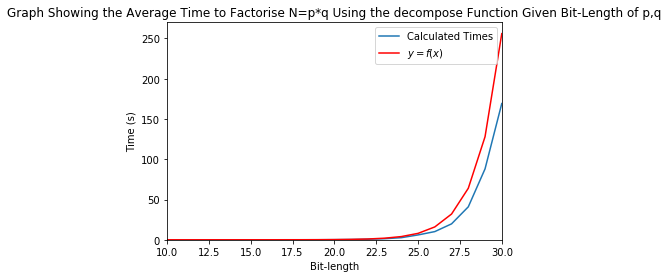

In [75]:
plt.plot(range(10,31),times1, label = 'Calculated Times') #Here we plot the graph of time taken against bit length.
plt.ylabel('Time (s)') 
plt.xlabel('Bit-length')
plt.title('Graph Showing the Average Time to Factorise N=p*q Using the decompose Function Given Bit-Length of p,q') #Here we add a title and labels.
plt.plot(x,y,color='red', label = '$y = f(x)$') #Here we plot the line y = f(x), with f(x) defined above. 
plt.xlim([10,30]) #Here we reframe the ranges of both axes to make the graph easier to read.
plt.ylim([0,270])
plt.legend()

As we can see from the comparison between the blue line and the red line on the graph above, we have that the average time taken to factorise $N=pq$ using the decompose function can approximately be modelled by the function $f(x)=2^{x-22}$, where we use such a function as an upper bound. Using this relationship, we can calculate, approximately, how many seconds it will take to factorise $N=pq$ for any bit-length. Thus, we can decide when it will be unfeasible to factorise $N$ in such a manner.

Below we have created a data frame that consists of a column containing bit-length and the approximate time in seconds to factorise $N = pq$, where $p$ and $q$ are a supposed bit length, using the decompose function. The approximate time has been calculated using the function $f(x)=2^{x-22}$. This is because, as discussed earlier, it works relatively well as an upper bound for our approximate time.

In [76]:
u = np.arange(30,51) #Here we create an array containg the values in the range from 30 up to and including 50.
v = np.zeros((51-30,)) #Here we create an empty array.
for i in range(51-30): #We enter values into the empty array according to the function f(x) defined above.
    v[i] = f(u[i])
l = np.transpose(np.array([v]))
df = pd.DataFrame(l) #Here we create a data frame using the arrays.
df.columns = ['time (s)'] #Here we relable the column title to make the dataframe clearer.
df.index = u
df.index.name = 'p, q bit-length'
print(df)

                    time (s)
p, q bit-length             
30                     256.0
31                     512.0
32                    1024.0
33                    2048.0
34                    4096.0
35                    8192.0
36                   16384.0
37                   32768.0
38                   65536.0
39                  131072.0
40                  262144.0
41                  524288.0
42                 1048576.0
43                 2097152.0
44                 4194304.0
45                 8388608.0
46                16777216.0
47                33554432.0
48                67108864.0
49               134217728.0
50               268435456.0


As we can see from the dataframe above, as the bit lengths of $p$ and $q$ surpass $30$ and go towards $40$, the approximated time taken to factorise $N$ rises rapidly. We have that a $p$ and $q$ bit length of $30$ would lead to $N$ being factorised in just over $4$ minutes. For a bit length of $35$, this rises to just over $2$ hours. For a bit length of $40$, the approximate time is a little over $3$ days. Finally, a bit length of $50$ gives way to an approximate time of about $8.5$ years.

So, when does using decompose to factorise large $N$ become unfeasible? Arguably, the answer to such a question depends upon the circumstances involved. For someone who uses their computer every day, a time over $8$ hours would seem unfeasible. Thus, such a person would consider this method unfeasible past a $p$ and $q$ bit length of $37$. However, to a person who has a dedicated computer to try and do this, they may decide that anything with the range of a few days to a week was acceptable and thus would only consider this method unfeasible past a bit-length of $41$ or $42$. 

## Security and Time Complexity of RSA and the Decompose Function

This section is based on ideas in [15] and [18].

For integer factorisation to pose a threat to the security RSA encryption, the factorisation must be able to be computed quickly. Since each pair of primes are randomly generated and used only once, it is clear that the primes serve no purpose to an attacker if the factorisation algorithm is only complete $500$ hours after the message is sent. Data from our decompose function shows that with integers greater than $50$ digits, factorisation could potentially take hundreds of hours. RSA encrypted typically employs a key size $1,024$ or $2,048$ or $4,096$ bits where $1024$ bits translates to $309$ digits. Clearly, our decompose function is not equipped to factorise an RSA key to produce primes in a short enough time to pose a threat to security.

The integer factorisation problem poses great significance in the mathematical and computing communities and thus more intricate methods have been developed to factorise $N$. Since our decompose function struggles with number larger than $37$ bits, mathematicians have implemented a highly optimised general number field sieve which runs on hundreds of machines. In February 2020, an $829$ bits, $250$ decimal digit number was factored; the largest such semi-prime yet. The total computation time was roughly $2700$ core-years of computing, highlighting the fact that although large numbers can be factored, the time taken is too great to pose a threat to RSA.

No algorithm has been published that can factor all integers in polynomial time so we cannot assign the integer factorisation problem a definitive time complexity measure. However, for $n$ bit numbers the time taken for factorisation increases non-linearly and exponentially. Therefore we can claim that the time complexity is $O(n^k)$ where $n$ is the number of bits and $k$ is a constant yet to be determined.

The problem does not yet have any efficient way of finding two prime factors for large semi-primes so clearly our problem is in the class NP. However, it has not been proved whether it is or isn't NP complete but it is generally suspected that it isn't.

# Part 5 - Pollard's Rho Method 

This section is based on ideas found in [19] and [20].

In this section we will again generate composite numbers $N = pq$, where $p$ and $q$ are primes, and time how long it takes for Pollard's Rho Method to factorise such numbers. We will then compare these times with the times taken by our decompose function and conjecture at which bit-length Pollard's Rho Method becomes unfeasible.

Pollard's Rho method is another method used to factorise large integers. Suppose we have $N = pq$ where $p$ and $q$ are prime numbers. Since we do not know $p$ and $q$, we wish to factorise $N$ in order to find them. Firstly, we select $k$ numbers in a random manner to get a sequence $x_1,x_2,...,x_k$ such that for each $x_i$, where $i \in [1,k]$, we have that $x_i \in [0,N-1]$. We make the assumption that all of the numbers are distinct, which is likely if $N$ is a lot larger than $k$. As long as we select $k$ reasonably, we have an extremely high probability that the following holds: $$\text{For some } i,j \in [1,k], \text{ we have that } x_{i} \equiv x_{j} \mod{p}.$$

This is true due to the Birthday Paradox and is explored in further detail here***. Thus, we have that $p|x_{i}-x_{j}$ and $p|N$ and thus we have that $p|\gcd(x_{i}-x_{j},N).$ Furthermore, since $-N\leq x_{i}-x_{j} \leq N$ and $x_{i} \neq x_{j}$, we have that $\gcd(x_{i}-x_{j},N) \leq N$. Thus $\gcd(x_{i}-x_{j},N)$ is a non-trivial factor of $N$ and hence we can use this to find $p$ and $q$.

Earlier, we mentioned that we must pick $k$ 'reasonably'. We have that $k \approx \sqrt{p}$ is a reasonable choice and since $p\leq \sqrt{N}$, we have that $k \approx N^{\frac{1}{4}}$ is what we will usually select. This is because $p$ is unknown. Furthermore, the most important part of the Pollard-Rho method is to pick the sequence $x_1,x_2,...,x_k$ in a pseudo-random fashion. We have that the function $f(x) = x^{2} + 1 \mod{N}$ can be used to create a pseudo-random sequence by letting $x_{i} = f(x_{i-1})$ where $x_{0}$ is some chosen constant. It has been proven empirically that this sequence using the defined function will create a pseudo-random sequence. 

Now, since we are assuming that there exists some $i,j \in [1,k]$ such that $x_i \equiv x_j \mod{p}$, we have that $f(x_i)\equiv f(x_j) \mod{p}$ and thus $x_{i+1} \equiv x_{j+1}$. Since this process continues, we have that eventually the sequence of $x_{0}\mod{p},x_{1}\mod{p},...$ will 'run into itself' and loop around before then, continuing in a cycle. This idea when plotted form the shape of a $\rho$ and is what gives the method its name. More importantly, however, is that this means we can make the entire process more efficient.

To take advantage of the fact that the sequence will eventually start to repeat in a loop, we use this idea of the 'tortoise and hare' algorithm. In other words, we choose  constant $x_0 = y_0$ as before and let the 'tortoise' be represented by $x_i = f(x_{i-1})$ whilst the 'hare' is represented by $y_i = f(f(y_{i-1}))$. Thus we have the $x_i$'s compute the sequence at a normal pace whilst the $y_i$'s compute the sequence at twice the speed. Thus, we will quickly be able to determine where the loop in the sequence is as the $y_i$'s will eventually 'catch-up' with the $x_i$'s and start repeating the 'tortoise' sequence. Thus, as soon as $\gcd(x_i-y_i,N) \neq 1$, we have found our factor and we can return it. Since $N = pq$ and $p$,$q$ are prime, we have that the factor returned will be equal to either $p$ or $q$ and thus we have factorised $N$.

In [77]:
def pollard_rho(N,a): #We have two inputs, the integer N we wish to factorise and our intial condition a which we will use to generate our pseudo-random sequence.
    def f(x, N):
        return((x**2 + 1)% N) #Here we define a function that has empirically been proven to create a pseudo-random sequence.
    a = f(a,N) #This is the 'tortoise'.
    b = f(f(a,N),N) #This is the 'hare'.
    while b != a: 
        a = f(a,N) #Once again, here we have the 'tortoise' and the 'hare'.
        b = f(f(b,N),N)  
        p = gcd(abs(b - a), N) #We calculate the gcd and check if it is not equal to 1.
        if p > 1:
            q = int(N/p) #We then calculate q and return p,q.
            return(p,q)
    return('Failed')

We now write a function used to calculate $N$ with a given bit-length.

In [78]:
def genN(bit_length): #We have the desired bit-length as the input.
    while True: #We essentially loop until we reach a N that has the desired bit-length.
        p,q = rsa_private_key(ceil(bit_length/2)) #Here we use our rsa-private-key function to generate two primes p,q so we can calculate N=p*q. We use the ceiling of half the bit length because multiplying two numbers of half the bit length will give either a number of the desired bit length, plus or minus 1.
        N = p*q 
        if len(bin(N)) == bit_length + 2: #Here we check the generated N is indeed of the desired bit-length.
            return(N)

Now we write a function to calculate the average time taken for the pollard_rho function to factorise $N$ of a given range of bit-lengths.

In [79]:
def average_time_pollard_rho(l,s,r):
    avg_array = np.zeros((s-l,)) #Here we create an empty array consisting of s-l entries. This will hold the average times.
    N_array = np.zeros((s-l,)) #This is similar but will hold the average value for the generated N for each bit-length.
    for j in range(l,s): #We are iterating over the varying bit-lengths.
        Nlist = [] #Here we create an empty list to store our values of N.
        while len(Nlist) < r: #Here we use a while loop to iterate over the number of trials we are doing.
            Nlist.append(genN(j)) #Here we calculate N and store it in the list.
        N_array[j-l,] = np.mean(Nlist) #Here we calculate the average N generated and store it in the empty array generated earlier. This is so we can plot a specific value for N on our graph later.
        start = timer()
        for m in range(r): #Here we iterate over r and use pollard_rho to factorise each N stored in the list. We time the entire process using timer().
            pollard_rho(Nlist[m],2)
        end = timer()
        total_time = end - start #We then calculate the total time take to factorise all the values of N.
        avg_array[j-l] = total_time/r  #Then we find the average time taken for each value of N and store it in the original array.
    return(N_array, avg_array) #We then return the average N generated for each bit length and the corresponding average time taken to factorise an N of such a bit-length.

Now we will generate a range of data points using our function above. Also we will generate data using our generated $N$ values by calculating corresponding data points according to $C \cdot N^{0.25}$ where $C$ is a chosen constant.

In [80]:
a = 30 #Here we set the range of the bit-lengths we will test.
b = 50
r = 50 #This is the number of N we will generate in order to get an average.
N, times2 = average_time_pollard_rho(a,b,r)

In [81]:
y = np.zeros((b-a,)) 
for i in range(b-a):
    y[i] = 0.00001*(N[i]**0.25)

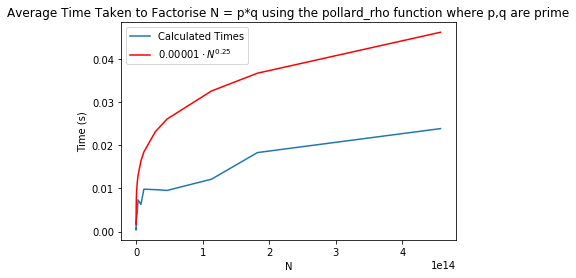

In [82]:
plt.plot(N,times2, label = 'Calculated Times')
plt.plot(N,y, color = 'red', label = '$0.00001 \cdot N^{0.25}$')
plt.title('Average Time Taken to Factorise N = p*q using the pollard_rho function where p,q are prime')
plt.xlabel('N')
plt.ylabel('Time (s)')
plt.legend()

As we can see from the graph above, the time taken to factorise $N$ using the pollard_rho function is approximately $O(N^{0.25})$.

Now, we wish to compare the time taken to factorise large $N$ given our two different methods: the decompose function and Pollard's rho method. Currently, we have that the average_time_decompose function we wrote takes an input of the bit_lengths of $p$ and $q$ and not $N$ as our pollard_rho function does. Thus we will write a new function average_time, which takes the bit-length of $N$ as an input and outputs the average times taken to facorise such a $N$ using both of decompose function and our pollard_rho function.

In [83]:
def average_time(l,s,r): #Again we take inputs incuidng the range of bit-length and the number of N we want to generate.
    avg_array_decompose = np.zeros((s-l,)) #Here we create two arrays, one for the decompose and one for pollard_rho.
    avg_array_pollard_rho = np.zeros((s-l,))
    for j in range(l,s): 
        Nlist = []
        while len(Nlist) < r:
            Nlist.append(genN(j)) #This time we generate N based off the bit-length. 
        start1 = timer() #First we time the decompose function.
        for m in range(r):
            decompose(Nlist[m])
        end1 = timer()
        start2 = timer() #Then we time the pollard_rho function. This is all in a similar manner to how our other functions worked.
        for m in range(r):
            pollard_rho(Nlist[m],2)
        end2 = timer()
        total_time1 = end1 - start1 #We then find the total times for bother functions as well as the average times.
        total_time2 = end2 - start2
        avg_array_decompose[j-l] = total_time1/r 
        avg_array_pollard_rho[j-l] = total_time2/r
    return(avg_array_decompose, avg_array_pollard_rho) #We return both the average times for the decompose funtion and the average times for the pollard_rho function. 

Now we can create a dataframe that compares the average times taken (to $6$ decimal places) to factorise $N$ of a certain  bit-length using both the decompose function and the pollard_rho function.

In [84]:
decompose_times, pollard_times = average_time(30,51,4)

In [85]:
u = np.arange(30,51) #Here we create an array containg the values in the range from 30 up to and including 50.
l = np.transpose(np.array([decompose_times,pollard_times]))
df = pd.DataFrame(l) #Here we create a data frame using the arrays.
df.columns = ['decompose time (s)', 'pollard_rho time (s)'] #Here we relable the column titles to make the dataframe clearer.
df.index = u
df.index.name = 'N bit-length'
print(df)

              decompose time (s)  pollard_rho time (s)
N bit-length                                          
30                      0.006453              0.000971
31                      0.012720              0.000564
32                      0.014022              0.001027
33                      0.019389              0.001157
34                      0.019364              0.000830
35                      0.033245              0.001958
36                      0.064662              0.003827
37                      0.129127              0.005215
38                      0.100448              0.002299
39                      0.153497              0.004500
40                      0.174078              0.002607
41                      0.292954              0.005114
42                      0.382324              0.004472
43                      0.580893              0.005833
44                      0.894960              0.006027
45                      1.142536              0.004253
46        

As we can see from the dataframe above, we have that the pollard_rho function is a lot faster than the decompose function for factorising large $N = pq$ where $p$ and $q$ are prime numbers. We have that in some cases, the speed of pollard_rho is more than $100$ times faster than that of decompose. For example, for a $N$ bit-length of $50$, we have that decompose took on average $5.726562$ seconds, to $6$ decimal places, to factorise $N$ whereas pollard_rho took only $0.039062$ seconds, to $6$ decimal places. Furthermore, it can also be seen that the times for pollard_rho are more erratic than those of decompose. For example, the pollard_rho times frequently deviate from a pattern altough they do have the general trend of increasing as the bit-length increases. We can see this as from bit-lengths $40$ to $50$, we see the time taken by the pollard_rho function increase from $0.003906$ to $0.039062$. However, there is also deviation as a bit-length of $49$ gave an average time of $0.054688$ which is larger than the time taken for the bit-length of $50$. This can probably be explained due to the number of trials done being relatively small and therefore some of the measurements may not be as accurate. On the other hand, the decompose function is much more regular and the time taken steadily rises as the bit-length of $N$ does, in a much more obvious fashion.

We will now consider the pollard_rho function as the bit-length of $N$ increases further. We have from our graph that we can see that the function $f(N) = 0.00001\cdot N^{0.25}$ approximates the time taken to factorise $N$ using the pollard_rho function. Hence, we can use this function to get an approximation of how long it would take to factorise a $N$ of $80$ bits or $100$ bits and so forth. This will allow us to get a general idea of when the pollard_rho function becomes unfeasible.

In [86]:
def pollardf(N): #Here we define the function discussed earlier that we can use to model the times taken to factorise N using the pollard_rho function.
    return(0.00001*(N**0.25))

In [87]:
a = 50 #Here we set the range of bits we will calculate an approximate time for.
b = 150
calc_time = np.zeros(((b-a)+1,)) #Here we create an empty array to store our times in.
for j in range(a,b+1): #We iterate over the bit-length of N.
    listN = [] 
    listtime = []
    while len(listN) <100:
        listN.append(genN(j)) #Here we generate 100 values of N at each bit-length.
    for i in range(100):
        listtime.append(pollardf(listN[i])) #We then calculate an approximate time for each N in the list and store those times in another list.
    calc_time[j-a] = np.mean(listtime) #Finally, we store an average of the times for each bit-length in the initial array.

In [88]:
u = np.arange(a,b+1) #Here we create an array of the bit-lengths.
l = np.transpose(np.array([calc_time]))
df = pd.DataFrame(l) #Here we create a data frame using the arrays.
df.columns = ['time (s)'] #Here we relable the column title to make the dataframe clearer.
df.index = u
df.index.name = 'N bit-length'
print(df)

                  time (s)
N bit-length              
50            5.187621e-02
51            6.505646e-02
52            7.387877e-02
53            9.255486e-02
54            1.046660e-01
...                    ...
146           8.758946e+05
147           1.102692e+06
148           1.229544e+06
149           1.555547e+06
150           1.743866e+06

[101 rows x 1 columns]


We can pull out the data for the bit-lengths of $120,130,140$ and $150$ so we can see at a glance how the time is rising over an interval of $10$ bits.

In [89]:
df.loc[[120,130,140,150],:] #Here we pull out several rows of the dataframe so we can see the difference in times at several intervals.

,time (s)
N bit-length,
120,9.633035e+03
130,5.471046e+04
140,3.080007e+05
150,1.743866e+06


As we can see from the dataframe above, we have that as the bit-length of $N$ increases so does the time taken to factorise it using the pollard_rho function. At a bit-length of $120$, it takes $9590$ seconds (to $3$ significant figures) to factorise $N$ using pollard_rho. This is a little under $3$ hours. However, at a bit-length of $130$, we see it takes about $15$ hours. At $140$ bits, it takes approximately $3.5$ days. Finally, at $150$ bits, we see it takes about $1740000$ seconds ($3$ s.f) which is approximately $20$ days. 

Again, the question of feasibility depends upon the computing power available to a person as well as the reasoning for them needing to factorise such large $N.$ For most people, anything more than a couple hours would be unfeasible and so one would consider a maximum bit-length for $N$ of $120$. However, for those with significantly more computing power, and a particular desire to factorise larger numbers, one may consider anything up to several days fairly acceptable. In this case, a bit-length of $140$ would be where it starts to become unfeasible.

## Security and Time Complexity of Pollard's Rho Method

The following is based on ideas in [21] and [22].

We have that the number of iterations of Pollard's Rho Method is generally considered to be $O(\sqrt{p})$ or equivalently $O(\sqrt[4]{N})$ where $N$ is the composite number we are factorising and $p$ is the smallest factor of such $N$. We have that this is based on the ideas of the Birthday Paradox which heavily influence the ideas behind Pollard's Rho Method. We have that the Birthday Paradox suggests that a group of $23$ people is a large enough group to ensure that in $50\%$ of cases, two people in such a group share the same birthday. This idea can be developed to suggest that upon picking numbers randomly from a set containing $p$ numbers, we have that the probability of picking a particular number exceed $50\%$ when $1.177 \cdot \sqrt{p}$ numbers have been picked. However, this really applies to Pollard's theoretical method where actual random numbers are used. In reality, pseudo-random numbers are used. However, the same ideas are thought to be applicable to the version of Pollard's Rho Method that is actually used but this has not been rigorously proved.

## Pollard's P-1 Algorithm

The following is based on ideas in [23] and [24].

Another method to factorise large integers was also invented by Pollard in 1974, the year before he invented his Rho Method. It is called Pollard's P-1 Algorithm. The algorithm uses Fermat's Little Theorem, which states that for prime $p$ and integer $a$, such that $p \nmid a$, we have that $$a^{p-1} \equiv 1 \mod{p}.$$

The method entails selecting suitably large numbers, say $M$, such that we hope that for a prime factor of $N$, denoted $p$, we have that $p-1\mid M.$ Thus, we have that for some constant integer $k$, $M = k(p-1).$ Hence, by Fermat's Little Theorem, we have that for some $a$ co-prime to $N$, we have that $$a^{M} = a^{k(p-1)} = (a^{p-1})^{k} \equiv 1^{k} = 1 \mod{p}.$$

Thus, we have that $p \mid a^{M} - 1$ and thus $\gcd(a^{M} - 1,N) = p$ or $\gcd(a^{M} - 1,N) = N$. In the former case the method has produced a non-trivial factor of $N$ and we are done. However, in the latter case, we must continue.

If $gcd(a^{M} - 1, N) = N$, then we have that $N \mid a^{M} - 1$ and thus the other prime factor of $N$, say $q$ is such that $q \mid a^{M} - 1$. Thus we have that $a^{M} \equiv 1 \mod q$.

Furthermore, we have by the Division Theorem that for some $b$ and $r$, we have that $M = b(q - 1) + r$, where $0 \leq r < q-1.$ Thus we have by The Division Theorem and Fermat's Little Theorem that $$a^{M} = a^{b(q-1) + r} = (a^{q-1})^{b}a^{k} \equiv 1^{b}a^{k} = a^{k} \mod  q.$$

Since $a^{M} \equiv 1 \mod q$ and $a^{M} \equiv a^{k} \mod q$, we have that $a^{k} \equiv 1 \mod q.$ So we have two cases: either $k = 0$ or $k \neq 0$. In the latter, we have that we can go back to the start of the algorithm and pick another $a$ and repeat the process whilst hoping that this time we get a non-trivial factor. Wheras, with the former, we have that $q-1 \mid M$ and this is problematic. Thus, in this case we would want to select a new $M$ such that $q-1 \nmid M$.

To select our $M$ originally, we multiply a list of primes up to a certain number $B$ where each prime is raised to a certain exponent. This is done to create a large number that has many different primes as factors as it makes it more likely that $p-1 \mid M$. Thus, if our $M$ is problematic, we can increase or decrease $B$ to get a differing list of primes and thus a differing $M$.

We now write a function to carry out Pollard's P-1 Algorithm. It takes an input of a composite number $N = pq$ where $p$ and $q$ are primes. It also takes a second value as an input. This is $B$, the bound we use to decide which primes will be appended into our prime list in order to create $M$, our large number that we hope is divisible by $p-1$.

In [90]:
def pollard_p1(N,B):
    primes = [] #Here we create an empty list of primes.
    for p in range(B+1): #Here we append all primes up to our B.
        if is_prime(p):
            primes.append(p)
    M = 1
    for p in primes: #Here we calculate M by multiplying up the primes in our list to the specified exponent.
        exponent = floor(log(B,p))
        M = M*(p**(exponent))
    if N%2 != 0: #We have if N is odd then 2 is co-prime.
        a = 2
    else:
        test = False
        while not test: #Alternately, we have to generate random integers in the range of 0 to N and see if they are co-prime to N.
            i = randint(0, N)
            if gcd(i,N) == 1:
                a = i
                test = True
    factor = gcd(((a**M) - 1)%N, N) #We then calculate the gcd of A^{M} - 1 and N. We do so modulo N becuase it makes the numbers more manageable and does not change the gcd.
    if factor != 1 and factor != N: #If our factor is non-trivial then we return it alongside the other factor.
        return(factor,int(N/factor))
    elif factor == 1: #Alternatively, if our factor = 1, we have that our list of primes is not big enough as there existed no factors of N, say p, where p-1 was B-smooth.
        B += 1
        while not is_prime(B):
            B += 1 #Hence, we increase B until we reach the next prime and thus the list of primes is longer.
        return(pollard_p1(N,B)) #We then repeat the process.
    elif factor == N: #Alternatively, if our gcd = N, then for all factors p, of N, we have that p-1 was B-smooth and thus we need to reduce the number of primes in the list.
        B -= 1
        while not is_prime(B): #Thus we reduce the number of primes until there is one less prime in the list.
            B -= 1
        return(pollard_p1(N,B)) #We then repeat the process.

We have that the time for the algorithm to complete depends on our choice of $B$. In our code above, we have written it in such a way that if the algorithm fails to produce a factor, we adjust $B$ accordingly until we find a factor. However, this can lead to memory problems with larger numbers as the length of time for the algorithm to run depends upon the size of the $B$ being used at the time. The larger $B$ gets, the more likely that a factor will be found but simultaneously this increases the length of time the algorithm takes to run. In our code above, we have that our algorithm will continue indefinitelty until it either runs out of memory or finds a factor. Very occasionally, the algorithm will not work as it will find two consecutive values of $B$ to be too small and too big respectively and thus alternate between the two. 

We will now run some assertion tests to show the functionality of Pollard's P-1 Method.

In [91]:
plist = [13,37,73,131,829] #Here we create two lists of primes that will be p and q.
qlist = [13,43,107,211,859]
for i in range(len(plist)):
    p,q = plist[i],qlist[i] #We assign p,q to be each element in the respective lists.
    print('We have that p = ' + str(p) + ' and q = ' + str(q) + '.')
    N = p*q #Here we create a composite N which we will factorise using our function.
    print('We have that N = ' + str(N) + '.')
    factors = list(pollard_p1(N,5)) #Here we factorise our N.
    factors.sort() #We then sort the factors into size order and assign p to be the smaller factor and q the larger.
    pfactor, qfactor = factors[0],factors[1]
    print('We have that our pollard_p1 function gives p = ' + str (pfactor) + ' and q = ' + str(qfactor) + '.')
    assert pfactor == p, qfactor == q #Finally, we assert that our factors produced from the function are indeed our original factors.

We have that p = 13 and q = 13.
We have that N = 169.
We have that our pollard_p1 function gives p = 13 and q = 13.
We have that p = 37 and q = 43.
We have that N = 1591.
We have that our pollard_p1 function gives p = 37 and q = 43.
We have that p = 73 and q = 107.
We have that N = 7811.
We have that our pollard_p1 function gives p = 73 and q = 107.
We have that p = 131 and q = 211.
We have that N = 27641.
We have that our pollard_p1 function gives p = 131 and q = 211.
We have that p = 829 and q = 859.
We have that N = 712111.
We have that our pollard_p1 function gives p = 829 and q = 859.


As we can see from our assert statements above, the pollard_p1 function works for varying sizes of $N$. However, the algorithm itself does have some downfalls, as mentioned earlier, and is dependent on the choice of $B$ chosen, among other things. Furthermore, the memory needed for such a function means that as $N$ starts to get even larger, the method becomes unfeasible. The method is relatively quick when $p-1$ has a lot of factors but this is not always the case. Therefore, as $N$ gets a lot larger, we have that this method becomes unfeasible and thus pales in comparison to more powerful methods we have already discussed such as the decompose function and Pollard's Rho Method. Hence, this method would not be very effective in use and is also relatively slow in comparison to the others as well as not working all of the time.

## Dixon's Factorisation Method

This section is based on ideas in [25] and [26].

Dixon's Factorisation Method is an algorithm invented by John Dixon and published in 1981. Although it is not the fastest method for factorising large integers, it is the precursor to more modern methods such as the Quadratic Sieve Method and the General Number Field Sieve which are considered to be the fastest two methods for factorising smaller and larger integers respectively.

Dixon's method consists of first selecting a bound $B$. It is from this bound $B$, that we assemble a list of primes to be our factor base: a small set of prime numbers which we can factorise integers over. So, our base consists of all primes $p$ such that $p \leq B$. We call this set $P$.

Next, we find $\lceil\sqrt{N}\rceil$, the ceiling of the square root of $N$. This allows us a start point to begin our search at. We only have to check from $\lceil\sqrt{N}\rceil$ to $N$ itself because an two distinct factors of $N$,say $p$ and $q$, have the property that either $p \geq \sqrt{N}$ or $q \geq \sqrt{N}$. Thus there will always exist one factor of $N$ in the range $[\lceil\sqrt{N}\rceil, N]$. Of course, if $N = p^2$ for some $p$, then we check this first and act accordingly. 

Presuming that $N$ has two distinct factors, we start finding $z^{2} \mod N$ for each $z \in [\lceil\sqrt{N}\rceil, N]$. We then collect all those $z$ such that they are considered $B-smooth$. That is, all $z$ such that  $z^{2} \mod N$ can be written as $\prod_{p_{i} \in P}{p_{i}^{a_i}}$. 

We store all such $z$ that are $B-smooth$ as well as vectors $a = (a_{1},a_{2},...,a_{k})$ where each $a_i$, for $i \in [1,k]$ where $k$ is the number of primes in $P$, is the exponent of prime $p_i$ in the prime factorisation of the previously calculated $z^{2} \mod N$.

So, we now have two lists: a list of $B-smooth$ $z$ values and a corresponding list of exponents of the prime factorisations. We shall call these lists $Z$ and $A$ respectively. We continue to collect $z$ values and $a$ vectors to our list until we have slightly more values than the number of primes in $P$. This will give us a high probability of finding a factor.

Now, Dixon's Method suggests we go through $A$ and find the first vector $a \in A$ which is linearly dependent on previous vectors. We denote this vector $c$. We then remove $c$ and its corresponding $z$ value, denoted $z_{c}$, from the lists $A$ and $Z$ respectively. We then compute coefficients $f_a$, which are either $1$ or $0$, such that $$c \equiv \sum_{a \in A}{f_{a}a} \mod 2. $$

Then, we let $d = (d_1,d_2,...,d_k) = \frac{1}{2}(c + \sum_{a \in A}{f_{a}a})$. Penultimately, we define $x = z_{c}\prod_{a}{z_{a}^{f_a}}$, where $z_a$ are the $z$ values related to the vectors $a$, and $y = \prod_{i}{p_{i}^{d_i}}$. Thus we have that $x^{2} \equiv y^{2} \mod N$. Now, if $x \equiv y \mod N$ or $x \equiv -y \mod N$, then the algorithm has failed and it should be repeated with a new value for $B$. However, this is rare and almost always we will have no such case and thus $gcd(x + y, N)$ will return a non-trivial factor of $N$.

In [92]:
def dixon(N,B):
    primes = [] #Here we create an empty list of primes.
    for p in range(B+1):
        if is_prime(p):
            primes.append(p) #Here we append all primes in our 'base' up to and including 'B'.
    start = ceil(sqrt(N)) #Here we find our start point by finding the square root of N.
    if start**2 == N: #We first check if N is a sqaure number and start is the square root of N.
        return(start,start)
    for i in range(start,N): #We iterate over all numbers from the square root of N to N-1.
        for j in range(len(primes)): #We also iterate over all primes in our 'base' list.
            a = i**2%N #We find the square of all numbers from start to N modulo N.
            b = primes[j]**2%N #We find the squares of all the primes in our 'base' modulo N.
            if a == b: #We then compare to see when we have a match/pair.
                factor = gcd(i - primes[j], N) #We then test to see if the numbers used to find this pair give a non-trivial factor.
                if factor != 1 and factor != N:
                    return(factor,int(N/factor))

Once more, we can show the efficacy of the function with some randomly generated values for $N$ and some assert statements.

In [93]:
for i in range(5,14): #We iterate over bit-lengths for p and q.
    initial = list(rsa_private_key(i)) #Here we make a list of two random prime numbers.
    initial.sort() #We then sort this list.
    p,q = initial[0],initial[1] #We then let p be the smallest factor and q the larger one. This will help with our assert statements.
    print('We have that p = ' + str(p) + ' and q = ' + str(q) + '.')
    N = p*q #Here we create a composite N which we will factorise using our function.
    print('We have that N = ' + str(N) + '.')
    factors = list(dixon(N,7)) #Here we factorise our N.
    factors.sort() #We then sort the factors into size order and assign p to be the smaller factor and q the larger.
    pfactor, qfactor = factors[0],factors[1]
    print('We have that our dixon function gives p = ' + str (pfactor) + ' and q = ' + str(qfactor) + '.')
    assert pfactor == p, qfactor == q #Finally, we assert that our factors produced from the function are indeed our original factors.

We have that p = 31 and q = 31.
We have that N = 961.
We have that our dixon function gives p = 31 and q = 31.
We have that p = 43 and q = 53.
We have that N = 2279.
We have that our dixon function gives p = 43 and q = 53.
We have that p = 83 and q = 113.
We have that N = 9379.
We have that our dixon function gives p = 83 and q = 113.
We have that p = 151 and q = 163.
We have that N = 24613.
We have that our dixon function gives p = 151 and q = 163.
We have that p = 419 and q = 509.
We have that N = 213271.
We have that our dixon function gives p = 419 and q = 509.
We have that p = 653 and q = 967.
We have that N = 631451.
We have that our dixon function gives p = 653 and q = 967.
We have that p = 1583 and q = 1889.
We have that N = 2990287.
We have that our dixon function gives p = 1583 and q = 1889.
We have that p = 2351 and q = 4019.
We have that N = 9448669.
We have that our dixon function gives p = 2351 and q = 4019.
We have that p = 4421 and q = 5323.
We have that N = 23532983.
W

As we can see from our assert statements above, there are no errors and thus our dixon function is working. We have used a range of bit-lengths for $p$ and $q$ from $5$ to $14$ to show the function works for varying sizes of $N$. We have that the bit-length could increase but the time taken to factorise larger $N$ using Dixon's Method is considerable.

Dixon's Method is slower than both Pollard's Rho Method and our decompose function. However, it can factorise larger values of $N$ more comfortably than Pollard's P-1 Method. 

Dixon's Method is more interesting when considering the fact it lays the basis for some of the more efficient factorisation methods used today. Furthermore, Dixon's Method is unique in that the time comlpexity can be explicitly stated unlike other methods of factorisation. In fact Dixon's Method has a complexity of $O(\exp(2\sqrt{2}\sqrt{\log{N}\log{\log{N}}})),$ under the assumption of optimal complexity.

# Part 6 - Diffie-Hellman Key Exchange

This section is based on ideas in [27].

In this section, we will outline and implement the Diffie-Hellman protocol. We will show examples of this using both two and three people, and show how the Diffie-Hellman can be used in conjuction with the Vigenere Cipher to encrypt/decrypt messages.

The Diffie-Hellman protocol is a way of privately exchanging a shared secret between two parties. The process starts with two parties/people (Alice and Bob) sharing publicly a large (in our case, 256-bit) prime number, $p$, and a primitive root (base), $g$, such that $g^{p-1}$ $\equiv1$ (mod $p$) and $g^{t}$ $\neq$ $1$ (mod $p$) for all $0 < t < p − 1$. Alice and Bob also seperately and privately choose their own large (256-bit) numbers. Alice then publically sends Bob the number $A = g^{a}$ (mod $p$) and Bob publically sends Alice $B = g^{b}$ (mod $p$). Alice then computes the shared secret $S = B^{a}$ (mod $p$) which should be the same as Bob computing the shared secret $S = A^{b}$ (mod $p$). Hence both Alice and Bob are in possession of the secret key $S$. After all parties are in possession of the secret key $S$, they are able to send each other messages and decrypt the messages that they receive from each other.  

The Diffie-Hellman is used in the security of a variety of internet communication services. This is due to the fact that it is a fairly straight-forward technique that can use very large numbers for it's encryption, making it incredibly difficult to crack. However, research now suggests that the protocol is no longer strong enough to stop it from being hacked by some of the wealthiest and most skilled attackers. 


## Diffie-Hellman Protocol with Two People

This section is based on ideas in [28].

We start by defining each of the variables, and display these to the user.

*Note because of the size of these numbers, this section of code can sometimes take longer to run

In [94]:
def find_prim_root_safe(p): 
    error = 'Input not a safe prime'
    q = (p-1)//2
    if is_sg_prime(q) == False:
        print('Input not a safe prime')
        return error
    else:
        for i in range(2,p + 1):
            if is_prim_root_safe(i,p) == True:
                return i
            
a = random_prime(256)
while is_sg_prime(a) == False: # Using a 'while' loop that continues to generate random 256-bit prime numbers until a Sophie-German prime, 'Prime' is found
    a = random_prime(256)
    if is_sg_prime(a) == True:
        Prime = a # p

Base = find_prim_root_safe(2*Prime + 1) # g

# Generating Alice and Bob's secret keys
def Private_keys(n):
    keys = []
    for i in range (0,n):
        bits = False
        while bits == False:
            x = getrandbits(256)
            if x.bit_length() == 256:
                keys.append(x)
                bits = True
    return keys # Returns a list of 'n' elements that can be used as the private keys for Alice and Bob when n = 2
    
keys = Private_keys(2)
aSecret = keys[0] # a
bSecret = keys[1] # b

# Setting up the code and the immediately ouputting the publicly shared variables for the user to see
print( "Publicly shared variables:")
print( "    Publicly shared prime: " , Prime )
print( "    Publicly shared base:  " , Base )


Publicly shared variables:
    Publicly shared prime:  65091362820760091838155888296112101052638407382944318614045528947228321838483
    Publicly shared base:   5


Computing the Diffie-Hellman algorithm using the variables and outputting their shared secret

In [95]:
# Alice Sends Bob A = g^a mod p
A = pow(Base, aSecret, Prime)
print( "Alice sends over public channel:" , A )
# Bob Sends Alice B = g^b mod p
B = pow(Base, bSecret, Prime)
print( "Bob sends over public channel:", B )
print( "\n" )

# Alice Computes Shared Secret: S (key) = B^a mod p
secret = pow(B, aSecret, Prime)
# Bob Computes Shared Secret: S (key) = A^b mod p
secret = pow(A, bSecret, Prime)
print( "Privately calculated shared secret (Key):", secret )

Alice sends over public channel: 14068559695212578080421963549318367219948841742918785473817889785485695068078
Bob sends over public channel: 49742947646626313573624269871743626079429015902460455214748903803862303985060


Privately calculated shared secret (Key): 37827745190262827167619546457848054156190601703951754394405421698046542298698


Now we move onto the Vigenere encryption using the previously calculated shared secret as the key for encryption. We paste in the code for the Vigenere Cipher as it was made earlier in the assignment, but first have to make adjustments to the key so that it can be used in the Vigenere.

In [96]:
print('Vigenere Encryption')

letters1 = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
letters2 = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

# Manipulating the 'secret' calculated with the Diffie-Hellman, so that it can be used with the Vigenere Cipher
key = ''
for i in str(secret):
    p = int(i)
    key += letters1[p] # I.e. the key is now the letters associated with the string of numbers calculated using the Diffie-Hellman earlier, with respect to the list, 'letters1'

pyperclip.copy(key) # Copy the key to the clipboard to help the user with decryption

# Paste in the code for the Vigenere cipher such that Alice and Bob's privately calculated secret can be used as the key
def vig(txt='', key='', typ=''):

    if not txt: 
        print('Needs text')
        return
    if not key: 
        print('Needs key')
        return
    if typ not in ('d', 'e'):
        print('Type must be "d" or "e"')
        return
    
    key = key.upper() # Using the key we calculated with the Diffie-Hellman from earlier
    alist = [] 
    
    keyInd = 0 
    for i in txt: 
        num = letters2.find(i.upper())
        if num != -1: 
            if typ == 'e':
                num += letters2.find(key[keyInd]) 
            elif typ == 'd':
                num -= letters2.find(key[keyInd]) 
            num %= len(letters2) 
            alist.append(letters2[num])    
            keyInd += 1  
            if keyInd == len(key):
                keyInd = 0 
        else:
            alist.append(i)
    if typ == 'e':
        print('Key has been copied to clipboard for use in decryption') # Displays to user that the key has been copied to their computer, only shows if they have used the encryption type
    return print('Cipher -', ''.join(alist))


vig('hello', key, 'e')
print('\n')
print('Now for decryption:')
vig('JGPOT', 'CCEDFFGEJIIADIHFFGJHHHGFFHDFIDJHGBBEEEGIEDAGACGBEDFBGAHBIHEEIGADAIFHEGIBIJGJA', 'd')

Vigenere Encryption
Key has been copied to clipboard for use in decryption
Cipher - KLTNV


Now for decryption:
Cipher - HELLO


As you can see, we have created a key with Alice and Bob's publicly shared numbers and the randomly generated 256-bit prime, using the Diffie-Hellman protocol. We have then used this key to encrypt the word 'hello' using the Vigenere Cipher, an algorithm that was made earlier on in this project file.

## Diffie-Hellman Protocol with Three People

This section is based on ideas in [29].

We now introduce a third person, Cate. Similarly to the two person arrangement, Cate has her own private number, $c$. She then sends $C = g^{c}$ (mod$p$) to Alice and Cate herself receives $B = g^{b}$ (mod $p$). Next, Cate sends Alice $C^\prime = B^{c}$ (mod $p$) and receives $B^\prime = A^{b}$ (mod $p$). The shared secret is then calculated as $s =$ ($B^\prime$)$^{c}$ (mod $p$) $= g^{abc}$ (mod $p$).

In the same way as we did for two people, we randomly calculate and output the public numbers, aswell as calculating the now three secret 256-bit numbers.

*Note because of the size of these numbers, this section of code can sometimes take longer to run

In [97]:
# Below random is used to generate a random 256-bit number
#random_prime is used so that we can generate a random 256-bit prime number
#find_prim_root_safe is used to find the 'Base'
#is_sg_prime needed to ensure 'Prime' is a Sophie-Germain prime


a = random_prime(256)
while is_sg_prime(a) == False: # Using a 'while' loop that continues to generate random 256-bit prime numbers until a Sophie-German prime, 'Prime' is found
    a = random_prime(256)
    if is_sg_prime(a) == True:
        Prime = a # p

Base = find_prim_root_safe(2*Prime + 1) # g

# Generating the Secret keys for Alice, Bob and Cate
def Private_keys(n):
    keys = []
    for i in range (0,n):
        bits = False
        while bits == False:
            x = getrandbits(256)
            if x.bit_length() == 256:
                keys.append(x)
                bits = True
    return keys # Returns a list of 'n' elements that can be used as the private keys for Alice, Bob and Cate when n = 3
keys = Private_keys(3)
aSecret = keys[0]
bSecret = keys[1]
cSecret = keys[2]

# Printing the publicly shared variables for the user to see
print( "Publicly Shared Variables:")
print( "    Publicly Shared Prime: " , Prime )
print( "    Publicly Shared Base:  " , Base )
 

Publicly Shared Variables:
    Publicly Shared Prime:  103601909586284043319650565098575618437797160612339089063587605302287802843389
    Publicly Shared Base:   2


Again compute the Diffie-Hellman algorithm but now with three people so the output will be three keys that are all the same number.

In [98]:
# Alice Sends Bob A = g^a mod p
A = pow(Base, aSecret, Prime)
print( "Alice Sends Over Public Channel:", A )

# Bob Sends Cate B = g^b mod p
B = pow(Base, bSecret, Prime)
print( "Bob Sends Over Public Channel:", B )

# Cate Sends Alice C = g^c mod p
C = pow(Base, cSecret, Prime)
print( "Cate Sends Over Public Channel:", C)
print('\n')
# Alice Sends Bob Aprime = C^a mod p
Aprime = pow(C, aSecret, Prime)
print( "Alice Sends Over Public Channel:", Aprime)

# Bob Sends Cate Bprime = A^b mod p
Bprime = pow(A, bSecret, Prime)
print( "Bob Sends Over Public Channel:", Bprime)

# Cate sends Alice Cprime = B^c mod p
Cprime = pow(B, cSecret, Prime)
print( "Cate Sends Over Public Channel:", Cprime)

# Alice Computes Shared Secret: s = Cprime^a mod p
secret = pow(Cprime,aSecret, Prime)

# Bob Computes Shared Secret: s = Aprime^b mod p
secret = pow(Aprime,bSecret, Prime)

# Cate Computes Shared Secret: s = Bprime^c mod p
secret = pow(Bprime, cSecret, Prime)
print('\n')

print( "Privately Calculated Shared Secret (Key):", secret)

Alice Sends Over Public Channel: 47471324341274024766001337656528211238650337801656289770101617277247193891514
Bob Sends Over Public Channel: 74891792752441555238356716541343831301815820741012739051749272338179201264082
Cate Sends Over Public Channel: 61800818451905756222045502239098177806712631531467751627288890722661328443088


Alice Sends Over Public Channel: 88791241836196750449624908253926664913036684233113123782663243403392555671162
Bob Sends Over Public Channel: 38445155956272736086069113706663046875534989225463436446143330947118497254051
Cate Sends Over Public Channel: 89082305216967602379155574212343485263530253404764762494031488751763436307016


Privately Calculated Shared Secret (Key): 34221941716734408702142236069087675945586484167530949510547489051324487772725


Finally we again use the code for the Vigenere Cipher paired with our shared key to encrypt the message.

In [99]:
print('Vigenere Encryption:')
print('')

letters1 = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
letters2 = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

# Manipulating the 'secret' calculated with the Diffie-Hellman, so that it can be used with the Vigenere Cipher
key = ''
for i in str(secret):
    p = int(i)
    key += letters1[p] # I.e. the key is now the letters associated with the string of numbers calculated using the Diffie-Hellman earlier, with respect to the list, 'letters1'

pyperclip.copy(key)

# Again paste in the code for the Vigenere cipher but this time such that Alice, Bob and Cate's privately calculated secret will be used as the key
def vig(txt='', key='', typ=''):

    if not txt: 
        print('Needs text')
        return
    if not key: 
        print('Needs key')
        return
    if typ not in ('d', 'e'):
        print('Type must be "d" or "e"')
        return
    key = key.upper() # Using the key we calculated with the Diffie-Hellman from earlier
    alist = [] 
    keyInd = 0 
    for i in txt: 
        num = letters2.find(i.upper())
        if num != -1: 
            if typ == 'e':
                num += letters2.find(key[keyInd]) 
            elif typ == 'd':
                num -= letters2.find(key[keyInd]) 
            num %= len(letters2) 
            alist.append(letters2[num])
            keyInd += 1  
            if keyInd == len(key):
                keyInd = 0 
        else:
            alist.append(i)
    if typ == 'e':
        print('Key has been copied to clipboard for use in decryption')
    return print('Cipher -', ''.join(alist))


vig('HADLEIGH', key , 'e')
print('\n')
print('Now for decyption:')
vig('KJIMLMHP','DJFBHEBIGDFCGJCBBHIEDJJGHIIAHGIFCGCJGEHDFGJHGDJEJEIEAIIGIHBGBHGFBCEHJHDDJBBD', 'd')

Vigenere Encryption:

Key has been copied to clipboard for use in decryption
Cipher - KEFNFRKI


Now for decyption:
Cipher - HADLEIGH


# Part Seven - Solving the Discrete Logarithm Problem

We have that the security of the Diffie-Hellman protocol depends on the fact that, given $p$, $g$ and $A = g^a (mod p)$, it is not feasible to find $a$—otherwise, if we intercept $B$, we could compute the key $K = B^a$ . Finding this value of $a$ is whats known as the discrete logarithm problem and for large values of $a$ and $p$ this is hugely difficult. 
Nonetheless it can be done, and we will show how with two differnt methods; a Brute Force Algorithm and a method known as the Baby Step Giant Step Algorithm. We will use varying bit length of our $a$ and $p$ values. We will record the time taken for our two algorithms to 'spit out' our $a$ value to compare how the algorithm's vary in efficiency. 

## Brute Force Algorithm
Firstly, we will implement the Brute Force Algorithm to find our $a$ value. We will do this by firstly generating $M$ such that $M=g^a \mod p$ and then running the method to see how quickly it can find the $a$ value.

The Brute Force Algorithm is simple; it uses the pow function to go through all possible values of $a$ until it finds the correct value, starting at $a=1$ and increasing by $1$ each time until we reach a value of $g^a(mod p)$. such that $M=g^a(mod p)$ for our given $M$.

In [100]:
def random_int(bit_length):
    while True:
        p = SystemRandom().getrandbits(bit_length)
        if p.bit_length()==bit_length:
            return p
#Here we have created a function where by we can generate a random integer of a given bit-length.
#This will be used to generate different values of 'a' and 'p'.
#we have used the if statement to ensure the integer is of specified bit length and not any less.

In [101]:
def brute_force_algo(M,p,g):
    a=1
    while True:
        if pow(g,a,p) == M:
            return print('The Brute Force Algorithm has found that the value of a is ' + str(a) + '.')
        a += 1
#This is the Brute Force Algorithm, it essentially uses the pow function to go through possible values of a until
#it finds the correct value, starting at a=1 such that M=g^a(mod p).

Now we have established the method, we are going to see what effect is given by increasing the bit length of the $a$ and $p$ values used. We have started with a bit length of $20$ for both and will increase this and test the time taken for the method to 'spit out' the $a$ value. Although it was recommed to start with $30$ bit length variables, we found that this takes a huge amount of time and so values larger than $30$ bits would be inefficient. 

In [102]:
'''We will time how long it takes for higher bit values of a and p'''
#We will establish a timer which ends once the brute force algorithm finishes and returns the value of a.
timetotal=0
for i in range(1,6):
    #We run this 5 times.
    start = timer()
    bitlen=20 #We will start will 20 bit values of a and p.
    #We will increase this value and observe the effectiveness of our two algorithms in finding our a value.
    p=random_prime(bitlen)#We generate a random prime of a given bit length for our value of p.
    g=randint(2,100) #We also generate a random integer between 2 and 99 for g.
    a1=random_int(bitlen)
    m1=g**a1
    M=m1%p
    brute_force_algo(M,p,g)
    end = timer()
    time=end-start
    i=i+1
    timetotal=timetotal+time
    #We compile all the times together to later work out an average.
    print('Time total is ' + str(timetotal) + '.')
    
b20=timetotal/5
timetaken=b20
#Since we are running this 10 times, we then take an average of the total time taken.

print('The time for a ' + str(bitlen) + ' bit value of a and p is ' + str(timetaken) + ' seconds.')

The Brute Force Algorithm has found that the value of a is 138851.
Time total is 1.0438911000001099.
The Brute Force Algorithm has found that the value of a is 3407.
Time total is 1.3948476000000483.
The Brute Force Algorithm has found that the value of a is 34051.
Time total is 1.781502699999919.
The Brute Force Algorithm has found that the value of a is 25086.
Time total is 2.4322452999997495.
The Brute Force Algorithm has found that the value of a is 96374.
Time total is 3.480700399999705.
The time for a 20 bit value of a and p is 0.696140079999941 seconds.


In [103]:
#We repeat this for bit values of 21,22,23,24 and 25.
#With every increase in bit length, the time taken increases so note that 
#some of these may take a considerable amount of time since we are running
#them through 5 times

timetotal=0
for i in range(1,6): 
    start = timer()
    bitlen=21
    p=random_prime(bitlen)
    g=randint(2,100)
    a1=random_int(bitlen)
    m1=g**a1
    M=m1%p
    brute_force_algo(M,p,g)
    end = timer()
    time=end-start
    i=i+1
    timetotal=timetotal+time
    
b21=timetotal/5
timetaken=b21
print('The time for a ' + str(bitlen) + ' bit value of a and p is ' + str(timetaken) + ' seconds.')

The Brute Force Algorithm has found that the value of a is 656117.
The Brute Force Algorithm has found that the value of a is 688869.
The Brute Force Algorithm has found that the value of a is 18186.
The Brute Force Algorithm has found that the value of a is 593176.
The Brute Force Algorithm has found that the value of a is 1760270.
The time for a 21 bit value of a and p is 3.8239644799999497 seconds.


In [104]:
timetotal=0
for i in range(1,6): 
    start = timer()
    bitlen=22
    p=random_prime(bitlen)
    g=randint(2,100)
    a1=random_int(bitlen)
    m1=g**a1
    M=m1%p
    brute_force_algo(M,p,g)
    end = timer()
    time=end-start
    i=i+1
    timetotal=timetotal+time
    
b22=timetotal/5
timetaken=b22
print('The time for a ' + str(bitlen) + ' bit value of a and p is ' + str(timetaken) + ' seconds.')

The Brute Force Algorithm has found that the value of a is 1587980.
The Brute Force Algorithm has found that the value of a is 3251.
The Brute Force Algorithm has found that the value of a is 2315975.
The Brute Force Algorithm has found that the value of a is 210329.
The Brute Force Algorithm has found that the value of a is 1741240.
The time for a 22 bit value of a and p is 7.057041019999997 seconds.


In [105]:
timetotal=0
for i in range(1,6): 
    start = timer()
    bitlen=23
    p=random_prime(bitlen)
    g=randint(2,100)
    a1=random_int(bitlen)
    m1=g**a1
    M=m1%p
    brute_force_algo(M,p,g)
    end = timer()
    time=end-start
    i=i+1
    timetotal=timetotal+time
    
b23=timetotal/5
timetaken=b23
print('The time for a ' + str(bitlen) + ' bit value of a and p is ' + str(timetaken) + ' seconds.')

The Brute Force Algorithm has found that the value of a is 1975901.
The Brute Force Algorithm has found that the value of a is 646296.
The Brute Force Algorithm has found that the value of a is 102021.
The Brute Force Algorithm has found that the value of a is 5201661.
The Brute Force Algorithm has found that the value of a is 2060225.
The time for a 23 bit value of a and p is 12.736181080000005 seconds.


In [106]:
timetotal=0
for i in range(1,6): 
    start = timer()
    bitlen=24
    p=random_prime(bitlen)
    g=randint(2,100)
    a1=random_int(bitlen)
    m1=g**a1
    M=m1%p
    brute_force_algo(M,p,g)
    end = timer()
    time=end-start
    i=i+1
    timetotal=timetotal+time
    
b24=timetotal/5
timetaken=b24
print('The time for a ' + str(bitlen) + ' bit value of a and p is ' + str(timetaken) + ' seconds.')

The Brute Force Algorithm has found that the value of a is 173942.
The Brute Force Algorithm has found that the value of a is 6450600.
The Brute Force Algorithm has found that the value of a is 4885213.
The Brute Force Algorithm has found that the value of a is 9539667.
The Brute Force Algorithm has found that the value of a is 9451759.
The time for a 24 bit value of a and p is 42.654481080000004 seconds.


In [107]:
timetotal=0
for i in range(1,6): 
    start = timer()
    bitlen=25
    p=random_prime(bitlen)
    g=randint(2,100)
    a1=random_int(bitlen)
    m1=g**a1
    M=m1%p
    brute_force_algo(M,p,g)
    end = timer()
    time=end-start
    i=i+1
    timetotal=timetotal+time
    
b25=timetotal/5
timetaken=b25
print('The time for a ' + str(bitlen) + ' bit value of a and p is ' + str(timetaken) + ' seconds.')

The Brute Force Algorithm has found that the value of a is 1145066.
The Brute Force Algorithm has found that the value of a is 412353.
The Brute Force Algorithm has found that the value of a is 8436548.
The Brute Force Algorithm has found that the value of a is 5565810.
The Brute Force Algorithm has found that the value of a is 66334.
The time for a 25 bit value of a and p is 84.46505910000005 seconds.


Below we time how long it takes to generate the $M$ value for $27$ bits of $p$ and $a$ as this seems to take a considerable amount of time for large bit values of $a$ and $p$. If you look at the time values that are outputted by the running of the functions above they do not seem to correspond to the amount of time actually taken. This is because we only begin the timer once we have our $M$, $p$ and $g$ values.


In [ ]:
start = timer()
bitlen=27
p=random_prime(bitlen)
g=randint(2,100)
a1=random_int(bitlen)
m1=g**a1
M=m1%p
end = timer()
time=end-start
print('For 27 bits this has taken ' + str(time) + ' seconds.')

Any value of $a$ greater than $27$ bits takes far too long for this method to be feasible. However, as we have shown above, it is not necessarily the slowness of the Brute Force Alogrithm, but the time taken to calculate $M$ that makes this process slow.

If we look at the time taken for smaller bit values of $a$ and $p$, we can see there is not always a continual increase in time as the bit value increases, depending on which random values of $a$ and $p$ are generated. However, generally speaking, the larger the bit length of $a$ and $p$, the longer the Brute Force Method takes to find a solution.

## Baby Step Giant Step Algorithm
Now we will look at the Baby Step Giant Step algorithm. The Baby Step Giant Step Algorithm is a more complex process, esentially it works as a 'meet in the middle' algorithm. The Baby Step is as follows; we firstly need to find the square root of $p-1$ and take the ceiling value of this, which is to round up the value. We then generate a table of values, labelled x, of $g^i mod p$ where by $i$ is in the range 0 to $N$ where $N$ is the ceiling of $\sqrt{p-1}$. Once this table has been generated we then compute our c value which is $g^{N(p-2)} mod p$.
We then compute the Giant Step. To do this we generate values of $M^{c^j mod p} mod p$, where $j$ ranges from 0 to $N$, which we label as $y$ and then search for the point in $x$ such that $y=x$. When we find this point we then calculate $a$ which is $j(N)+x[y]$ where $x[y]$ is the location of $y$ in the table $x$ and $j$ is the counter value for when $y$ was in $x$.

This section is based off ideas in [30] and [31].

In [ ]:
def babygiant(M,p,g):
    N=ceil(sqrt(p-1))
    #ceil rounds up a decimal point, eg ceil(0.2)=1.
    #We firstly need to find the square root of p-1
    #for the baby step part of the method.
    x={pow(g,i,p):i for i in range(N)}
    #x is a table of all possible values that our actual x could be.
    c=pow(g,N*(p-2),p)
    #We compute g^-N to give our c value.
    for j in range(N):
        #We then search through the values of Mc^x (mod p)
        #until we find a match in our table x.
        #This is the giant step.
        y=(M*pow(c,j,p))%p
        if y in x:
            return print('The Baby Step Giant Step has found that the value of a is ' + str(j*N+x[y]) + '.')
    return print('There is no such a value.')
babygiant(20,53,5)

In order to explain how the Baby Step Giant Step Algorithm works we will use a simple example of $20 = 5^a (mod 53)$

We have that $M=20$, $p=53$ and $g=5$ in this case. 

Our $N$ value is going to be ceiling$(\sqrt{52})=8$ since $(\sqrt{52})=7.211102551$ which rounds up to $8$.

Then we produce a 'Baby Table' which we label '$x$'which will store $g^i (modp)$ in the form of {$g^i (mod p), i$}.

This gives us: 

{$1: 0, 3: 7, 5: 1, 51: 5, 42: 4, 43: 6, 19: 3, 25:2$} 

So if $i=0$ we get $5^0 (mod53)$ which give us {$1:0$}.

If $i=1$ we get $5^1 (mod 53)=5$ so {$5:1$}.

If $i=2$ we get $5^2 (mod 53)=25$ so {$25:2$}.

So subsequently we have a list of pairs from $0$ to $\sqrt{p-1}$.

Next we compute $g^{N(p-2)} (mod p)$ so in this case we have $c=5^{8(51)} (mod 53)$.

The next step is searching through values of $y=M(c^j (mod p)) mod p$ for $j$ ranging between $0$ and $8$ in this case. 

So for $j=0$ we have $y=20(c^0 (mod 53)) (mod 53)$  which is $20$ and we run this until we find a value of $y$ such that it is in the table we've made called x. 

In our case for $j=1$ we have $y=19$ and since $19$ is in our $x$ dictionary at point $3$, we stop the loop and we have that our $x[y]=3$, our $j=1$ and our $N=8$.

Finally, we know that our $a$ value is $j(N)+x[y]=1(8)+3$ which in this case we have $a=11$. This final stage is our 'Giant Step'.



In [ ]:
#We test this with simple values first.
print(babygiant(6,7,5))

We now run the two alogirthms with the same values to see which is quicker. Similarly to how we assessed the Brute Force Algorithm above, we will increase the bit length of $a$ and $p$ each time and see how this affects running time.

In [ ]:
timetotal1=0
timetotal2=0
#Here we use two time variables for our two different methods.
for i in range(1,6):
    #Again we use a for loop to run this test 10 times.
    bitlen = 20
    p=random_prime(bitlen)
    g=randint(2,100)
    a1=random_int(bitlen)
    m1=g**a1
    M=m1%p
    #We use the same M,p and g values for both algorithms to make it a comparable test.
    start = timer()
    brute_force_algo(M,p,g)
    end=timer()
    time1=end - start
    start = timer()
    babygiant(M,p,g)
    end=timer()
    time2=end - start
    #We add the new time taken for both variables to their total so we can take an average once we have generated
    #10 different times.
    timetotal1=timetotal1+time1
    timetotal2=timetotal2+time2
    i=i+1
#Now we have ran the loop 10 times, we can calculate an average for both methods and compare them.    
brutetime20=timetotal1/5
babytime20=timetotal2/5

print('The time taken for the Brute Force Algorithm for ' + str(bitlen) + ' bits is ' + str(brutetime20) + ' seconds.')
print('The time taken for the Baby Step Giant Step Algorithm for ' + str(bitlen) + ' bits is ' + str(babytime20) + ' seconds.')

In [ ]:
timetotal1=0
timetotal2=0
for i in range(1,6):    
    bitlen = 21
    p=random_prime(bitlen)
    g=randint(2,100)
    a1=random_int(bitlen)
    m1=g**a1
    M=m1%p
    start = timer()
    brute_force_algo(M,p,g)
    end=timer()
    time1=end - start
    start = timer()
    babygiant(M,p,g)
    end=timer()
    time2=end - start
    timetotal1=timetotal1+time1
    timetotal2=timetotal2+time2
    i=i+1
brutetime21=timetotal1/5
babytime21=timetotal2/5

print('The time for the Brute Force Algorithm for ' + str(bitlen) + ' bits is ' + str(brutetime21) + ' seconds.')
print('The time for the Baby Step Giant Step Algorithm for ' + str(bitlen) + ' bits is ' + str(babytime21) + ' seconds.')

In [ ]:
timetotal1=0
timetotal2=0
for i in range(1,6):    
    bitlen = 22
    p=random_prime(bitlen)
    g=randint(2,100)
    a1=random_int(bitlen)
    m1=g**a1
    M=m1%p
    start = timer()
    brute_force_algo(M,p,g)
    end=timer()
    time1=end - start
    start = timer()
    babygiant(M,p,g)
    end=timer()
    time2=end - start
    timetotal1=timetotal1+time1
    timetotal2=timetotal2+time2
    i=i+1
brutetime22=timetotal1/5
babytime22=timetotal2/5

print('The time for the Brute Force Algorithm for ' + str(bitlen) + ' bits is ' + str(brutetime22) + ' seconds.')
print('The time for the Baby Step Giant Step Algorithm for ' + str(bitlen) + ' bits is ' + str(babytime22) + ' seconds.')

In [ ]:
timetotal1=0
timetotal2=0
for i in range(1,6):    
    bitlen = 23
    p=random_prime(bitlen)
    g=randint(2,100)
    a1=random_int(bitlen)
    m1=g**a1
    M=m1%p
    start = timer()
    brute_force_algo(M,p,g)
    end=timer()
    time1=end - start
    start = timer()
    babygiant(M,p,g)
    end=timer()
    time2=end - start
    timetotal1=timetotal1+time1
    timetotal2=timetotal2+time2
    i=i+1
brutetime23=timetotal1/5
babytime23=timetotal2/5

print('The time for the Brute Force Algorithm for ' + str(bitlen) + ' bits is ' + str(brutetime23) + ' seconds.')
print('The time for the Baby Step Giant Step Algorithm for ' + str(bitlen) + ' bits is ' + str(babytime23) + ' seconds.')

In [ ]:
timetotal1=0
timetotal2=0
for i in range(1,6):    
    bitlen = 24
    p=random_prime(bitlen)
    g=randint(2,100)
    a1=random_int(bitlen)
    m1=g**a1
    M=m1%p
    start = timer()
    brute_force_algo(M,p,g)
    end=timer()
    time1=end - start
    start = timer()
    babygiant(M,p,g)
    end=timer()
    time2=end - start
    timetotal1=timetotal1+time1
    timetotal2=timetotal2+time2
    i=i+1
brutetime24=timetotal1/5
babytime24=timetotal2/5

print('The time for the Brute Force Algorithm for ' + str(bitlen) + ' bits is ' + str(brutetime24) + ' seconds.')
print('The time for the Baby Step Giant Step Algorithm for ' + str(bitlen) + ' bits is ' + str(babytime24) + ' seconds.')

In [ ]:
timetotal1=0
timetotal2=0
for i in range(1,6):    
    bitlen = 25
    p=random_prime(bitlen)
    g=randint(2,100)
    a1=random_int(bitlen)
    m1=g**a1
    M=m1%p
    start = timer()
    brute_force_algo(M,p,g)
    end=timer()
    time1=end - start
    start = timer()
    babygiant(M,p,g)
    end=timer()
    time2=end - start
    timetotal1=timetotal1+time1
    timetotal2=timetotal2+time2
    i=i+1
brutetime25=timetotal1/5
babytime25=timetotal2/5

print('The time for the Brute Force Algorithm for ' + str(bitlen) + ' bits is ' + str(brutetime25) + ' seconds.')
print('The time for the Baby Step Giant Step Algorithm for ' + str(bitlen) + ' bits is ' + str(babytime25) + ' seconds.')

In [ ]:
timetotal1=0
timetotal2=0
for i in range(1,6):    
    bitlen = 26
    p=random_prime(bitlen)
    g=randint(2,100)
    a1=random_int(bitlen)
    m1=g**a1
    M=m1%p
    start = timer()
    brute_force_algo(M,p,g)
    end=timer()
    time1=end - start
    start = timer()
    babygiant(M,p,g)
    end=timer()
    time2=end - start
    timetotal1=timetotal1+time1
    timetotal2=timetotal2+time2
    i=i+1
brutetime26=timetotal1/5
babytime26=timetotal2/5

print('The time for the Brute Force Algorithm for ' + str(bitlen) + ' bits is ' + str(brutetime26) + ' seconds.')
print('The time for the Baby Step Giant Step Algorithm for ' + str(bitlen) + ' bits is ' + str(babytime26) + ' seconds.')

We will now display our findings in a table and a graph, so we can directly compare how changing bit lengths of $a$ and $p$ change the processing times of the two algorithms.

In [ ]:
#We want to display our new information in a table and so we create three lists of our new times.
a=[20,21,22,23,24,25,26]
brutevals=[brutetime20,brutetime21,brutetime22,brutetime23,brutetime24,brutetime25, brutetime26]
babyvals=[babytime20,babytime21,babytime22,babytime23,babytime24,babytime25,babytime26]

#Now we will calculate the ratio of the times to see compartively how much
#slower the Brute Force Method is.
ratio=[]
for i in range(0,len(a)):
    diff=babyvals[i]/brutevals[i]
    ratio.append(diff)
    
values = np.transpose(np.array([a,brutevals,babyvals,ratio]))

#We use the pandas functions to generate this table.

df=pd.DataFrame(values)
df.columns = ['Bit Length of a and p', 'Brute Force Time Taken', 'BSGS Time Taken', 'Ratio']
df

So, we have from the table that the Baby Step Giant Step method is significantly quicker than the Brute Force Method. However the ratio is not a consistent value and as such, with this data set, we cannot say definitively how much quicker the BSGS method is.

In [ ]:
plt.plot(a, brutevals, label = 'Brute Force')
plt.plot(a, babyvals, label = 'Baby Step Giant Step')
plt.title('Graph Comparing Brute Force and Baby Step Giant Step')
plt.xlabel('Bit length of a and p')
plt.ylabel('Time(secs)')
plt.legend()
#We plot our time values for both methods and ranges of bit values to compare them.
#In this case the Brute Force method is in blue and the Baby Step Giant Step Method is in orange.
plt.show()

So clearly there is a huge difference between the time taken for the Brute Force Algorithm and the Baby Step Giant Step Algorithm.

In [ ]:
plt.plot(a, ratio)
plt.title('Graph Showing the Ratio of Times for a Given Bit Length')
plt.xlabel('Bit length of a and p')
plt.ylabel('Time taken for Brute Force/BSGS')
plt.show()

As we can see from the graph, the Baby Step Giant Step method is quicker, however there is still an issue when a large bit length is used. We have only been able to compare up to $26$ bits for $a$ and $p$, since the time taken to calculate $M$ takes too long with larger bit lengths.

Unfortunately, since we are limited to only running code that works in a reasonable time, we cannot calculate the time taken for larger bits. Nevertheless you can see that for the Brute Force Algorithm, the curve shown is not increasing linearly and so we can safely say that the time taken for the Brute Force would eventually become ridiculously long. 

Should we have a machine which was able to compute $M$ faster, or should we use values of $M$, $p$ and $g$ which we already knew to work for an unknown $a$, then we could do this process quicker, however when testing on integers of such large bit values, we aren't aware of solutions to $M=g^a (mod p)$ which we can use without having to work them out before hand. 

We have chosen to repeat each run of the algortithm ten times, to try and avoid the time being skewed by any anomalies, as anomalies were occuring before we introduced re-runs of the test. By this we mean on occasion for larger bit values of $a$ and $p$ we found that $a$ was found really quickly compared to smaller bit values and this did not fit with the overall trend. 

Nevertheless, we can conclude from our findings that the Brute Force Method is comparatively ineffective at solving our problem and the Baby Step Giant Step method is far superior.

# Conclusion

In this project, we have shown various approaches to encryption and decryption and delved into the security implications involved. We have discussed how these methods have changed over times as well as some of the modern day usages of them. We have considered some basic ciphers such as the Caesar, Vigenere and Affine Ciphers and showed how these can be easily broken. We then considered one of the most widely used encryption methods today: RSA. We showed how such a method can be implemented and also how to break such a method can be incredibly time-consuming. We looked at some different methods for attempting to break such a method including Pollard's Rho Method and Dixon's Factorisation Algorithm, although all were found to be inneffective and virtually useless when considering the size of primes used in RSA encryption. Thus, we came to the conclusion that such an encryption method is incredibly secure. We also examined the Diffie-Hellman Key Exchange and looked at how effective such a method can be with regards to encryption and decryption. Overall, this project has highlighted some strengths in modern day cryptography whilst also showing, using mathematical programming, how one may attempt to decipher messages encrypted in such a fashion using the aid of such tools as Python. 

# References

[1] Sweigart, A. (2016) $\textit{Invent Your Own Computer Games with Python, 4th Edition}$, No Starch Press, Chapter 14.

[2] Sweigart, A. (2017) $\textit{Cracking Codes With Python: An Inroduction to Building and Breaking Ciphers}$, No Starch Press, Chapter 18.

[3] https://en.wikipedia.org/wiki/Vigen%C3%A8re_cipher#/media/File:Vigen%C3%A8re_square_shading.svg

[4] Sweigart, A. (2017) $\textit{Cracking Codes With Python: An Inroduction to Building and Breaking Ciphers}$, No Starch Press, Chapters 6, 19 and 20.

[5]  Bruen, Aiden A. & Forcinito, Mario A. (2011). $\textit{Cryptography, Information Theory, and Error-Correction: A Handbook for the 21st Century}$, John Wiley & Sons

[6] https://www.dcode.fr/vigenere-cipher

[7] https://crypto.stackexchange.com/questions/3417/relative-security-of-a-vigenère-cipher

[8] Sweigart, A. (2017) $\textit{Cracking Codes With Python: An Inroduction to Building and Breaking Ciphers}$, No Starch Press, Chapters 14 and 15.

[9] Calderbank, M. (2007). $\textit{The RSA Cryptosystem: History, Algorithm, Primes}$, University of Chicago, Department of Mathematics

[10] Kleinjung, T. (2010). $\textit{Factorization of a 768-bit RSA modulus}$, Springer

[11] Zobrist, A. L. (1970). $\textit{A New Hashing Method with Application for Game Playing}$, University of Wisconsin-Madison 

[12] Naik, A. V.; Regan, K. W.; Sivakumar, D. (1995). On Quasilinear Time Complexity Theory. $\textit{Theoretical Computer Science}$, 148(2), pp. 325-349

[13] Harris, C. (2020). Mathematical Programming - Lecture 18, lecture notes, Mathematical Programming, Bristol University, delivered 21 April 2020 

[14] Rivest, R.; Shamir, A.; Adleman, L. (1978). $\textit{A Method for Obtaining Digital Signatures and Public-Key Cryptosystems}$.

[15] Robinson, S. (2003). $\textit{Still Guarding Secrets after Years of Attacks, RSA Earns Accolades for its Founders}$

[16] Weissman, M. H. (2017). $\textit{Python for number theory, Part 7: The RSA Cryptosystem in Python 3.x}$ available at https://nbviewer.jupyter.org/github/MartyWeissman/Python-for-number-theory/blob/master/P3wNT%20Notebook%207.ipynb

[17] Munzer Manzlgi, IOPub data rate exceeded in Jupyter notebook, https://stackoverflow.com/questions/43288550/iopub-data-rate-exceeded-in-jupyter-notebook-when-viewing-image

[18] Unknown. (2010). Solo Desktop Factorization of an RSA-512 Key, $\textit{No Tricks}$, available at http://lukenotricks.blogspot.com/2009/08/solo-desktop-factorization-of-rsa-512.html

[19] Goemans, M. (2015). Factoring, lecture notes, Principles of Discrete Applied Mathematics 18.310A, MIT, delivered 22 April 2015

[20] Pollard, J. M. (1975). A Monte Carlo Method for Factorization. $\textit{BIT Numerical Mathematics}$, 15(3), pp. 331–334.

[21] Lenstra, A. K. (2000). Integer Factoring. $\textit{Designs, Codes and Cryptography : An International Journal}$, 19(2-3), pp. 101–128.

[22] Galbraith, S. D. (2012). $\textit{Mathematics of public key cryptography}$, Cambridge: Cambridge University Press, Chapter 14

[23] Pollard, J. M. (1974). Theorems on Factorization and Primality Testing. $\textit{Mathematical Proceedings of the Cambridge Philosophical Society}$ 76(3), pp. 521–528.

[24] Pollak, R. (2018). $\textit{Pollard's p-1 Factorization}$, Pollak, available at: http://robin.pollak.io/wizard_factoring.pdf

[25] Dixon, J. D. (1981). Asymptotically fast factorization of integers. $\textit{Matematics of Computation}$, 36(153), pp. 255–260

[26] Nayal C. (2020). $\textit{Dixon’s Factorization Method with implementation}$, available at https://www.geeksforgeeks.org/dixons-factorization-method-with-implementation/

[27] https://www.comparitech.com/blog/information-security/diffie-hellman-key-exchange/

[28] Nazrul, S. S. (2019). Diffie-Hellman Key Exchange explained (Python), $\textit{Medium}$, available at https://medium.com/@sadatnazrul/diffie-hellman-key-exchange-explained-python-8d67c378701c

[29] https://crypto.stackexchange.com/questions/1025/can-one-generalize-the-diffie-hellman-key-exchange-to-three-or-more-parties

[30] Gasarch, W. (2015) $\textit{Baby-Step/Giant Step DL Algorithm}$, available at http://www.cs.umd.edu/~gasarch/COURSES/198/Su14/baby.pdf

[31] Buchanan, Prof. B. (2018). Baby-Step, Giant-Step: Solving Discrete Logarithms and Why It’s A Hard Problem To Solve, $\textit{Medium}$, available at https://medium.com/asecuritysite-when-bob-met-alice/baby-step-giant-step-solving-discrete-logarithms-and-why-its-a-hard-problem-to-solve-62b11bbe3088